All olf the codes are available in the following repo:<br>
Code: https://github.com/Attilasarkany/Elte-thesis <br>
The notebook contains the training part of the models. Some part of the clustering and data preparation can be found separately in the "DataPrep.py" file


In [ ]:


from Methods import preprocess,plot_probability_vs_adjclose,ad_clustering
from models import Logistic,rf,lightGBM
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import joblib
from sklearn.ensemble import VotingClassifier

# Load the dataset
### The loaded data contains the explanatory variables and the Target


The Target is calculated as follows  <br>1) identifying the local min and max by using argrelextrema from scipy<br>2) create a bullien where the difference is higher than a threshold (-20%),<br> 3) assing this bullien to the beginning of the crash, which is the index of the local max,<br>4) shift the index back in time (shift(-30)):<br>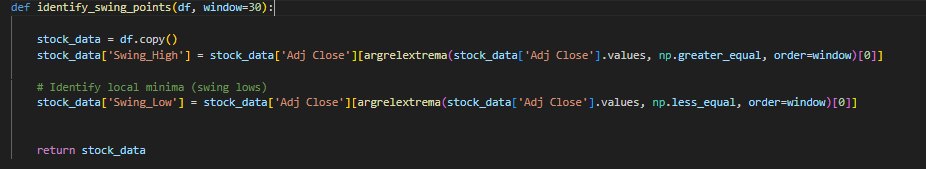 <br> In summary, we are intending to forecast the starting point (Swing high where the threshold condition met) of a crash, with the information available -30 days. <br> [Scipy Signal Argrelextrema Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelextrema.html)


In [130]:
# Load the dataset. 
with open('shifted_datasets_25_years.pkl', 'rb') as file:
    shifted_datasets= pickle.load(file)

In [131]:
# We will use the Final Target, which is the shifted value of the Target
shifted_datasets[-30].head()

,Target,RSI,MACD,MACD_H,MACD_S,5d_rolling_mean_Adj Close,15d_rolling_mean_Adj Close,30d_rolling_mean_Adj Close,45d_rolling_mean_Adj Close,65d_rolling_mean_Adj Close,...,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,Interest Coverage Ratio_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,Operating Margin_RollingPctChangeWindow4,Price-to-Earnings-Growth_RollingPctChangeWindow4,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Return on Invested Capital_RollingPctChangeWindow4,Short Term Coverage Ratio_RollingPctChangeWindow4,Tangible Asset Value_RollingPctChangeWindow4,Final_Target
2001-04-01,False,35.156656,-1.277191,-0.175413,-1.101779,18.80800,20.856447,21.688333,22.791111,25.496615,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-02,False,35.334380,-1.301350,-0.159657,-1.141693,18.58400,20.638667,21.543110,22.532889,25.275385,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-03,False,32.397538,-1.370860,-0.183334,-1.187526,18.52400,20.336000,21.370333,22.276667,25.042154,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-04,False,29.617208,-1.478302,-0.232620,-1.245681,18.20400,20.084667,21.168667,22.021556,24.796308,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-05,False,39.611373,-1.422784,-0.141682,-1.281102,18.18666,20.045333,20.967000,21.820889,24.571077,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False


In [92]:
shifted_datasets[-30].tail()

,Target,RSI,MACD,MACD_H,MACD_S,5d_rolling_mean_Adj Close,15d_rolling_mean_Adj Close,30d_rolling_mean_Adj Close,45d_rolling_mean_Adj Close,65d_rolling_mean_Adj Close,...,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,Interest Coverage Ratio_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,Operating Margin_RollingPctChangeWindow4,Price-to-Earnings-Growth_RollingPctChangeWindow4,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Return on Invested Capital_RollingPctChangeWindow4,Short Term Coverage Ratio_RollingPctChangeWindow4,Tangible Asset Value_RollingPctChangeWindow4,Final_Target
2023-11-25,False,66.103127,1.488193,-0.027200,1.515393,127.963,126.930333,124.916833,122.742111,122.549308,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.03782,False
2023-11-26,False,65.428095,1.421117,-0.075421,1.496538,127.987,127.104553,125.212833,123.010111,122.600846,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.03782,False
2023-11-27,False,64.716389,1.346786,-0.119802,1.466588,127.859,127.288333,125.501723,123.262556,122.651462,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.03782,False
2023-11-28,False,53.152792,1.169497,-0.237673,1.407169,127.514,127.399667,125.742500,123.474556,122.682231,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.03782,False
2023-11-29,False,47.088822,0.947866,-0.367443,1.315309,127.038,127.305667,125.949500,123.655667,122.699769,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.03782,False


In [93]:
shifted_datasets.keys()

dict_keys([-30, -60])

In [94]:
#Keep a subset of the dictionary. Our main goal is the -30 key
# These longer periods are more informative for risk managers
filtered_datasets = {k: shifted_datasets[k] for k in [-30] if k in shifted_datasets}
len(filtered_datasets)

1

preprocess function is responsible for making the train and test data. We will create 3 datasets for training:<br>
- Use random shuffling on the training
- short by date
- short by date and ticker.<br>
Note that we have cross sectional analysis if we short by date.The explanatory variables are moving averages of previous time step data<br>
Also, training data ordering should not effect of the outcome, this is just a verificaiton.

### we want to reduce the number of features by simple running the models and figoure out what 
### features to keep. We will use the most important features to decide<br>
This is not the best way to do. We will keep the 12 feautures per model.

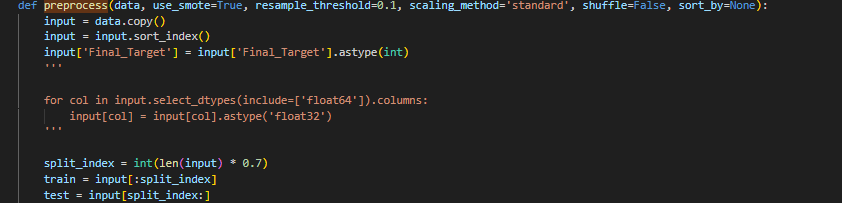

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


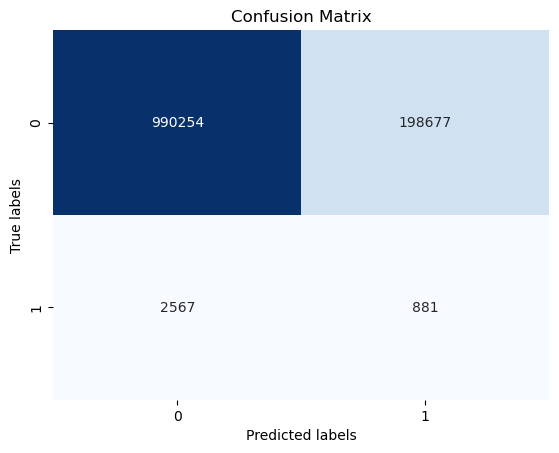

{-30: (array([0, 0, 0, ..., 0, 0, 0]),
  array([1, 0, 1, ..., 0, 1, 1]),
  {'AUC': 0.5726804585960207,
   'Train Balanced Accuracy': 0.569932379856762,
   'Test Balanced Accuracy': 0.5442024322406913,
   'Percentage of Negative Predictions': 0.8326387834740464,
   'Log Loss': 0.5741143144181302,
   'Confusion Matrix': array([[990254, 198677],
          [  2567,    881]], dtype=int64),
   'FPR (False Positive Rate)': array([0.00000000e+00, 7.65393450e-05, 3.28866856e-04, ...,
          9.99692160e-01, 9.99692160e-01, 1.00000000e+00]),
   'TPR (True Positive Rate)': array([0.00000000e+00, 2.90023202e-04, 2.90023202e-04, ...,
          9.99709977e-01, 1.00000000e+00, 1.00000000e+00]),
   'Thresholds': array([2.00000000e+00, 1.00000000e+00, 7.69835669e-01, ...,
          5.31116794e-04, 5.30355759e-04, 5.85956212e-08]),
   'Model': LogisticRegression(C=0.0001, class_weight='balanced'),
   'Feature Importance':                                               Feature  Importance
   9          

In [8]:
# Logictic
# shuffle=False
# 70 % for training
# it is result shuffle false and order date, just did not rewrite
results_shuffle_true_logistic = {}
for shift_val, df in filtered_datasets.items():
    X_train, X_test, y_train, y_test, test_index,feature_names = preprocess(df,use_smote=True, resample_threshold=0.1, scaling_method='power',shuffle=False,sort_by='date')
    preds, tr_preds, summary = Logistic(X_train, X_test, y_train, y_test,feature_names,C=0.0001)
    results_shuffle_true_logistic[shift_val] = (preds, tr_preds, summary)

results_shuffle_true_logistic

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


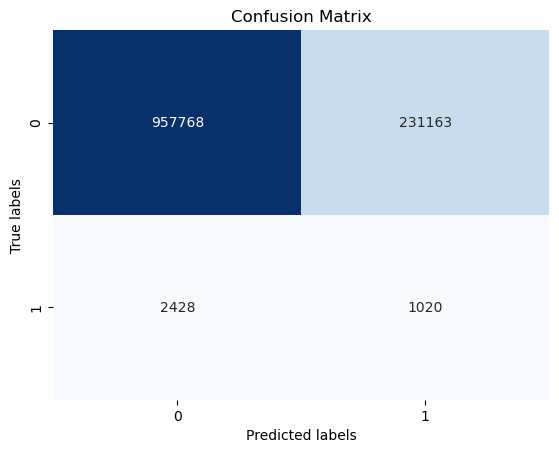

In [9]:
# For RF
# it is very slow
#it is result shuffle false and order date
results_shuffle_true_rf = {}
for shift_val, df in filtered_datasets.items():
    X_train, X_test, y_train, y_test, test_index,feature_names = preprocess(df,use_smote=False, resample_threshold=0.1, scaling_method='minmax',shuffle=False,sort_by='date')
    preds, tr_preds, summary = rf(X_train, X_test, y_train, y_test,feature_names,max_depth=7)
    results_shuffle_true_rf[shift_val] = (preds, tr_preds, summary)


In [10]:
results_shuffle_true_rf

{-30: (array([0, 0, 0, ..., 0, 0, 0]),
  array([1, 0, 1, ..., 1, 0, 0]),
  {'AUC': 0.5710856598116867,
   'Train Balanced Accuracy': 0.6426003169685868,
   'Test Balanced Accuracy': 0.5506971922315732,
   'Percentage of Negative Predictions': 0.8052775166285217,
   'Log Loss': 0.5829796070658547,
   'Confusion Matrix': array([[957768, 231163],
          [  2428,   1020]], dtype=int64),
   'Feature Importance':                                               Feature  Importance
   3                                              MACD_S    0.109644
   1                                                MACD    0.100216
   4                           5d_rolling_mean_Adj Close    0.099796
   5                          15d_rolling_mean_Adj Close    0.073281
   6                          30d_rolling_mean_Adj Close    0.063722
   7                          45d_rolling_mean_Adj Close    0.063526
   2                                              MACD_H    0.058489
   8                          65d_rol

In [11]:
top12_logistic = results_shuffle_true_logistic[-30][2]['Feature Importance'].nlargest(12, 'Importance')['Feature']
top12_logistic

9                         130d_rolling_mean_Adj Close
14                            65d_rolling_mean_Volume
15                           130d_rolling_mean_Volume
7                          45d_rolling_mean_Adj Close
8                          65d_rolling_mean_Adj Close
6                          30d_rolling_mean_Adj Close
12                            30d_rolling_mean_Volume
0                                                 RSI
10                             5d_rolling_mean_Volume
13                            45d_rolling_mean_Volume
5                          15d_rolling_mean_Adj Close
19    Interest Coverage Ratio_RollingPctChangeWindow2
Name: Feature, dtype: object

In [12]:
top12_rf = results_shuffle_true_rf[-30][2]['Feature Importance'].nlargest(12, 'Importance')['Feature']
top12_rf

3                                                MACD_S
1                                                  MACD
4                             5d_rolling_mean_Adj Close
5                            15d_rolling_mean_Adj Close
6                            30d_rolling_mean_Adj Close
7                            45d_rolling_mean_Adj Close
2                                                MACD_H
8                            65d_rolling_mean_Adj Close
9                           130d_rolling_mean_Adj Close
35    Return on Invested Capital_RollingPctChangeWin...
31    Operating Cash Flow to Sales Ratio_RollingPctC...
0                                                   RSI
Name: Feature, dtype: object

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.408725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

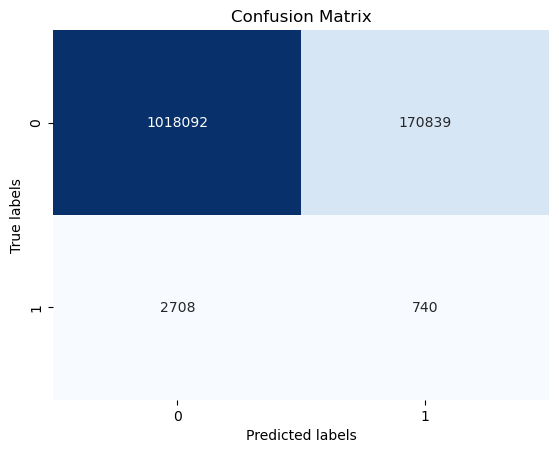

In [13]:
#it is result shuffle false and order date
results_shuffle_true_lightGBM = {}
for shift_val, df in filtered_datasets.items():
    X_train, X_test, y_train, y_test, test_index,feature_names = preprocess(df,use_smote=True, resample_threshold=0.1, scaling_method='power',shuffle=False,sort_by='date')
    preds, tr_preds, summary = lightGBM(X_train, X_test, y_train, y_test,feature_names,max_depth=7)
    results_shuffle_true_lightGBM[shift_val] = (preds, tr_preds, summary)

In [14]:
results_shuffle_true_lightGBM

{-30: (array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 1, 0, ..., 1, 1, 1]),
  {'AUC': 0.5658854793618039,
   'Train Balanced Accuracy': 0.7997704603464231,
   'Test Balanced Accuracy': 0.5354629519292811,
   'Percentage of Negative Predictions': 0.8561036381888645,
   'Log Loss': 0.4474464813554694,
   'Confusion Matrix': array([[1018092,  170839],
          [   2708,     740]], dtype=int64),
   'FPR (False Positive Rate)': array([0.00000000e+00, 8.41091703e-07, 3.36436681e-06, ...,
          9.99996636e-01, 9.99998318e-01, 1.00000000e+00]),
   'TPR (True Positive Rate)': array([0., 0., 0., ..., 1., 1., 1.]),
   'Thresholds': array([1.97935759, 0.97935759, 0.97771262, ..., 0.01097565, 0.01039077,
          0.00935986]),
   'Feature Importance':                                               Feature  Importance
   29  Free Cash Flow to Operating Cash Flow Ratio_Ro...         197
   23    Price-to-Free-Cash-Flow_RollingPctChangeWindow2         181
   31  Operating Cash Flow to Sales Ratio_Ro

In [15]:
top12_lightGBM = results_shuffle_true_lightGBM[-30][2]['Feature Importance'].nlargest(12, 'Importance')['Feature']
top12_lightGBM

29    Free Cash Flow to Operating Cash Flow Ratio_Ro...
23      Price-to-Free-Cash-Flow_RollingPctChangeWindow2
31    Operating Cash Flow to Sales Ratio_RollingPctC...
18    Free Cash Flow to Operating Cash Flow Ratio_Ro...
20    Operating Cash Flow to Sales Ratio_RollingPctC...
34      Price-to-Free-Cash-Flow_RollingPctChangeWindow4
19      Interest Coverage Ratio_RollingPctChangeWindow2
0                                                   RSI
1                                                  MACD
30      Interest Coverage Ratio_RollingPctChangeWindow4
33     Price-to-Earnings-Growth_RollingPctChangeWindow4
21             Operating Margin_RollingPctChangeWindow2
Name: Feature, dtype: object

It is very interesting. We had differnt set up in the models, but still I did not expect that the most important features are that different.

In [16]:
filtered_datasets[-30]

,Target,RSI,MACD,MACD_H,MACD_S,5d_rolling_mean_Adj Close,15d_rolling_mean_Adj Close,30d_rolling_mean_Adj Close,45d_rolling_mean_Adj Close,65d_rolling_mean_Adj Close,...,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,Interest Coverage Ratio_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,Operating Margin_RollingPctChangeWindow4,Price-to-Earnings-Growth_RollingPctChangeWindow4,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Return on Invested Capital_RollingPctChangeWindow4,Short Term Coverage Ratio_RollingPctChangeWindow4,Tangible Asset Value_RollingPctChangeWindow4,Final_Target
2001-04-01,False,35.156656,-1.277191,-0.175413,-1.101779,18.80800,20.856447,21.688333,22.791111,25.496615,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-02,False,35.334380,-1.301350,-0.159657,-1.141693,18.58400,20.638667,21.543110,22.532889,25.275385,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-03,False,32.397538,-1.370860,-0.183334,-1.187526,18.52400,20.336000,21.370333,22.276667,25.042154,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-04,False,29.617208,-1.478302,-0.232620,-1.245681,18.20400,20.084667,21.168667,22.021556,24.796308,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
2001-04-05,False,39.611373,-1.422784,-0.141682,-1.281102,18.18666,20.045333,20.967000,21.820889,24.571077,...,1.461599,6.466342,-1.405263,0.290407,-0.944726,-1.248106,-0.094595,-1.391673,0.235176,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-25,False,66.103127,1.488193,-0.027200,1.515393,127.96300,126.930333,124.916833,122.742111,122.549308,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.037820,False
2023-11-26,False,65.428095,1.421117,-0.075421,1.496538,127.98700,127.104553,125.212833,123.010111,122.600846,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.037820,False
2023-11-27,False,64.716389,1.346786,-0.119802,1.466588,127.85900,127.288333,125.501723,123.262556,122.651462,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.037820,False
2023-11-28,False,53.152792,1.169497,-0.237673,1.407169,127.51400,127.399667,125.742500,123.474556,122.682231,...,0.017566,0.114431,0.011224,0.078102,-95.820322,0.105797,0.117356,0.287225,-0.037820,False


In [17]:
# lets take the unions for the top 12 
mandatory_columns = {'Target', 'Quarter', 'Adj Close', 'Final_Target','Ticker'}
important_features_union = set(top12_lightGBM).union(set(top12_rf), set(top12_logistic))
columns_to_keep = list(mandatory_columns.union(important_features_union))
columns_to_keep


['45d_rolling_mean_Volume',
 'MACD_H',
 'Target',
 'Return on Invested Capital_RollingPctChangeWindow4',
 '130d_rolling_mean_Volume',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow4',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4',
 'MACD',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4',
 '5d_rolling_mean_Adj Close',
 'Quarter',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow2',
 '130d_rolling_mean_Adj Close',
 '45d_rolling_mean_Adj Close',
 'Interest Coverage Ratio_RollingPctChangeWindow4',
 'Price-to-Earnings-Growth_RollingPctChangeWindow4',
 'Operating Margin_RollingPctChangeWindow2',
 'MACD_S',
 '65d_rolling_mean_Volume',
 'RSI',
 '30d_rolling_mean_Adj Close',
 'Final_Target',
 '30d_rolling_mean_Volume',
 '65d_rolling_mean_Adj Close',
 'Adj Close',
 'Ticker',
 'Interest Coverage Ratio_RollingPctChangeWindow2',
 '15d_rolling_mean_Adj Close',
 '5d_rolling_mean_Volume',
 'Free Cash

In [132]:
# crashed many times, we need to save like this (from below)
columns_to_keep=['45d_rolling_mean_Volume',
 'MACD_H',
 'Target',
 'Return on Invested Capital_RollingPctChangeWindow4',
 '130d_rolling_mean_Volume',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow4',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4',
 'MACD',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4',
 '5d_rolling_mean_Adj Close',
 'Quarter',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow2',
 '130d_rolling_mean_Adj Close',
 '45d_rolling_mean_Adj Close',
 'Interest Coverage Ratio_RollingPctChangeWindow4',
 'Price-to-Earnings-Growth_RollingPctChangeWindow4',
 'Operating Margin_RollingPctChangeWindow2',
 'MACD_S',
 '65d_rolling_mean_Volume',
 'RSI',
 '30d_rolling_mean_Adj Close',
 'Final_Target',
 '30d_rolling_mean_Volume',
 '65d_rolling_mean_Adj Close',
 'Adj Close',
 'Ticker',
 'Interest Coverage Ratio_RollingPctChangeWindow2',
 '15d_rolling_mean_Adj Close',
 '5d_rolling_mean_Volume',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2']

In [23]:
important_features_union

{'130d_rolling_mean_Adj Close',
 '130d_rolling_mean_Volume',
 '15d_rolling_mean_Adj Close',
 '30d_rolling_mean_Adj Close',
 '30d_rolling_mean_Volume',
 '45d_rolling_mean_Adj Close',
 '45d_rolling_mean_Volume',
 '5d_rolling_mean_Adj Close',
 '5d_rolling_mean_Volume',
 '65d_rolling_mean_Adj Close',
 '65d_rolling_mean_Volume',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4',
 'Interest Coverage Ratio_RollingPctChangeWindow2',
 'Interest Coverage Ratio_RollingPctChangeWindow4',
 'MACD',
 'MACD_H',
 'MACD_S',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4',
 'Operating Margin_RollingPctChangeWindow2',
 'Price-to-Earnings-Growth_RollingPctChangeWindow4',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow2',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow4',
 'RSI',
 'Return on Invested Capital_RollingPctChangeWindow4'}

In [9]:
# we wanna keep the structure
df = filtered_datasets[-30]
df.columns

Index(['Target', 'RSI', 'MACD', 'MACD_H', 'MACD_S',
       '5d_rolling_mean_Adj Close', '15d_rolling_mean_Adj Close',
       '30d_rolling_mean_Adj Close', '45d_rolling_mean_Adj Close',
       '65d_rolling_mean_Adj Close', '130d_rolling_mean_Adj Close',
       '5d_rolling_mean_Volume', '15d_rolling_mean_Volume',
       '30d_rolling_mean_Volume', '45d_rolling_mean_Volume',
       '65d_rolling_mean_Volume', '130d_rolling_mean_Volume', 'Adj Close',
       'Ticker', 'Quarter', 'Cash Conversion Cycle_RollingPctChangeWindow2',
       'Debt-to-Equity Ratio_RollingPctChangeWindow2',
       'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2',
       'Interest Coverage Ratio_RollingPctChangeWindow2',
       'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2',
       'Operating Margin_RollingPctChangeWindow2',
       'Price-to-Earnings-Growth_RollingPctChangeWindow2',
       'Price-to-Free-Cash-Flow_RollingPctChangeWindow2',
       'Return on Invested Capital_RollingPctC

In [133]:


df=df[columns_to_keep]
df

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,21.688333,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,21.543110,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,21.370333,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,21.168667,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,20.967000,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-25,1.436518e+06,-0.027200,False,0.117356,1.468595e+06,0.105797,0.011224,1.488193,0.316211,0.017566,...,124.916833,False,1.398266e+06,122.549308,127.8300,YUM,0.219320,126.930333,8.078978e+05,0.070777
2023-11-26,1.417787e+06,-0.075421,False,0.117356,1.463184e+06,0.105797,0.011224,1.421117,0.316211,0.017566,...,125.212833,False,1.352157e+06,122.600846,127.7600,YUM,0.219320,127.104553,8.007057e+05,0.070777
2023-11-27,1.413141e+06,-0.119802,False,0.117356,1.463824e+06,0.105797,0.011224,1.346786,0.316211,0.017566,...,125.501723,False,1.321241e+06,122.651462,127.6900,YUM,0.219320,127.288333,8.333579e+05,0.070777
2023-11-28,1.411992e+06,-0.237673,False,0.117356,1.464640e+06,0.105797,0.011224,1.169497,0.316211,0.017566,...,125.742500,False,1.307281e+06,122.682231,126.3900,YUM,0.219320,127.399667,9.583098e+05,0.070777


In [11]:
# note: as discussed above one feature is different from original running. We did not rerun the whole code
# as only the very last feature for one model is different and also it is represented with other variables.
filtered_datasets[-30] = df
filtered_datasets[-30]

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,21.688333,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,21.543110,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,21.370333,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,21.168667,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,20.967000,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-25,1.436518e+06,-0.027200,False,0.117356,1.468595e+06,0.105797,0.011224,1.488193,0.316211,0.017566,...,124.916833,False,1.398266e+06,122.549308,127.8300,YUM,0.219320,126.930333,8.078978e+05,0.070777
2023-11-26,1.417787e+06,-0.075421,False,0.117356,1.463184e+06,0.105797,0.011224,1.421117,0.316211,0.017566,...,125.212833,False,1.352157e+06,122.600846,127.7600,YUM,0.219320,127.104553,8.007057e+05,0.070777
2023-11-27,1.413141e+06,-0.119802,False,0.117356,1.463824e+06,0.105797,0.011224,1.346786,0.316211,0.017566,...,125.501723,False,1.321241e+06,122.651462,127.6900,YUM,0.219320,127.288333,8.333579e+05,0.070777
2023-11-28,1.411992e+06,-0.237673,False,0.117356,1.464640e+06,0.105797,0.011224,1.169497,0.316211,0.017566,...,125.742500,False,1.307281e+06,122.682231,126.3900,YUM,0.219320,127.399667,9.583098e+05,0.070777


# Lets do a loop which helps to narrow down the prepocessing 
## Shuffle False and short by date only <br>
( Data ordering should not matter)

https://stackoverflow.com/questions/68197638/do-x-and-y-have-to-be-randomly-ordered-in-random-forest


In [25]:
def run_experiment(model_choice, shuffle_boolean, sort_by):
    results = {}

    # Configuration options
    use_smote_options = [True, False]
    resample_thresholds = [0.1, 0.2]
    scaling_methods = ['power', 'minmax']
    model_config = {
        'logistic': {'C': 0.0001},
        'lightgbm': {'max_depth': 7},
        'random_forest': {'max_depth': 7}
    }

    # Loop over each dataset
    for shift_val, df in filtered_datasets.items():
        best_train_acc = 0
        best_params = None
        best_test_acc = 0

        # Test all combinations of parameters
        for use_smote in use_smote_options:
            for threshold in resample_thresholds:
                for scaling in scaling_methods:
                    # Preprocess the data with the current set of parameters
                    X_train, X_test, y_train, y_test, test_index, feature_names = preprocess(
                        df,
                        use_smote=use_smote,
                        resample_threshold=threshold,
                        scaling_method=scaling,
                        shuffle=shuffle_boolean,
                        sort_by=sort_by
                    )
                    
                    # Fetch the specific parameters for the chosen model
                    specific_params = model_config[model_choice]

                    # Dynamically call the model function with unpacked specific parameters
                    if model_choice == 'logistic':
                        preds, tr_preds, summary = Logistic(X_train, X_test, y_train, y_test, feature_names, **specific_params)
                    elif model_choice == 'lightgbm':
                        preds, tr_preds, summary = lightGBM(X_train, X_test, y_train, y_test, feature_names, **specific_params)
                    elif model_choice == 'random_forest':
                        preds, tr_preds, summary = rf(X_train, X_test, y_train, y_test, feature_names, **specific_params)
                    
                    # Extract balanced accuracy from the summary
                    train_bal_acc = summary['Train Balanced Accuracy']
                    test_bal_acc = summary['Test Balanced Accuracy']

                    # Update best parameters based on best training balanced accuracy
                    # to avoid data leakage
                    # we save the test just for curiosity.
                    if train_bal_acc > best_train_acc:
                        best_train_acc = train_bal_acc
                        best_test_acc = test_bal_acc  # keep track of corresponding test accuracy
                        best_params = {
                            'use_smote': use_smote,
                            'resample_threshold': threshold,
                            'scaling_method': scaling,
                            'Train Balanced Accuracy': train_bal_acc,
                            'Test Balanced Accuracy': test_bal_acc,  # store test accuracy for reference
                            'model_choice': model_choice,
                            'shuffle': shuffle_boolean,
                            'sort_by': sort_by
                        }

        # Store the best parameters for this shift value
        results[shift_val] = best_params

    # Output results sorted by best training accuracy
    results_sorted = sorted(results.items(), key=lambda x: x[1]['Train Balanced Accuracy'], reverse=True)
    for result in results_sorted:
        print(f"Shift value: {result[0]}, Best Training Parameters: {result[1]}")

    return results


### Shuffle false and date ordering

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


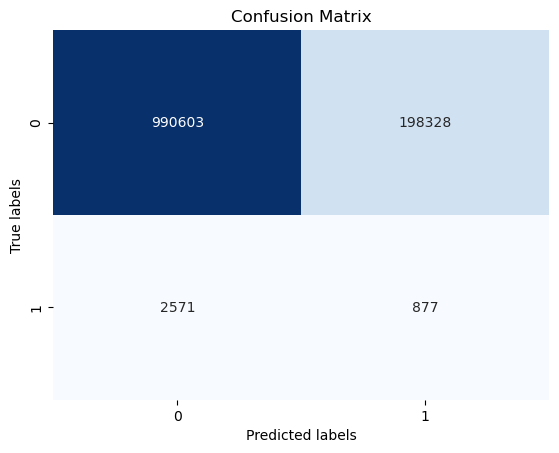

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


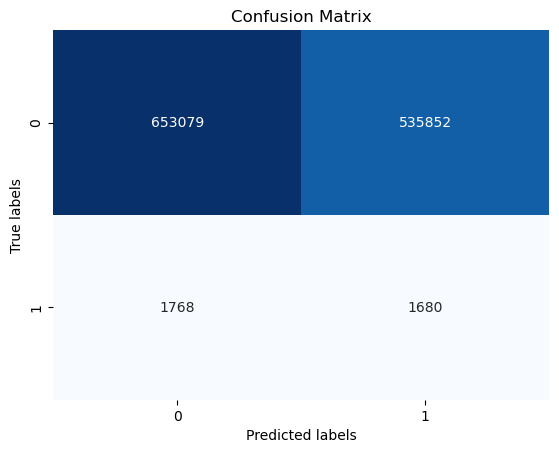

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


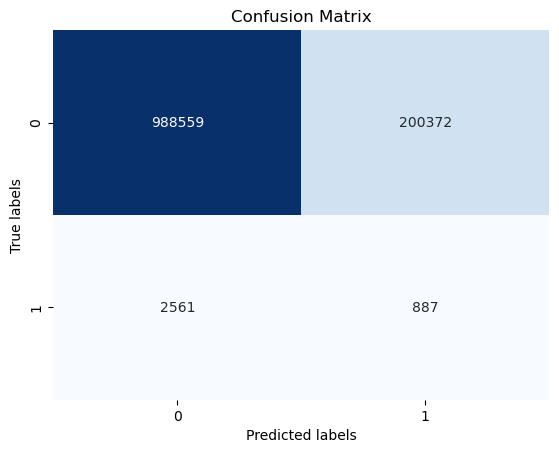

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


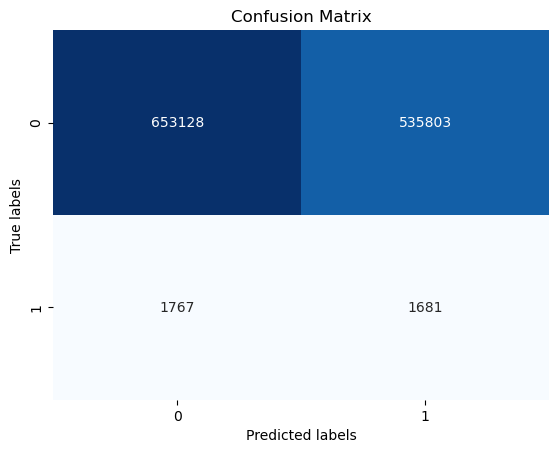

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


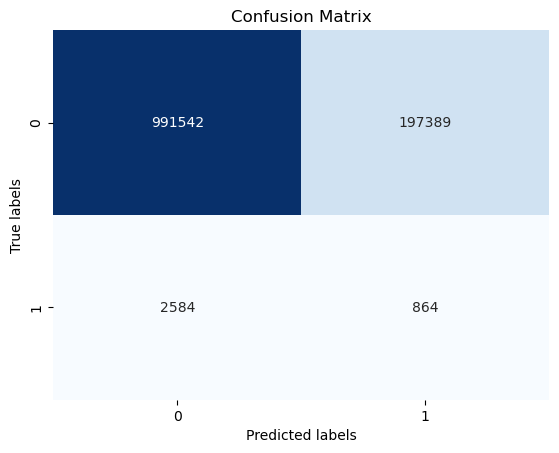

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


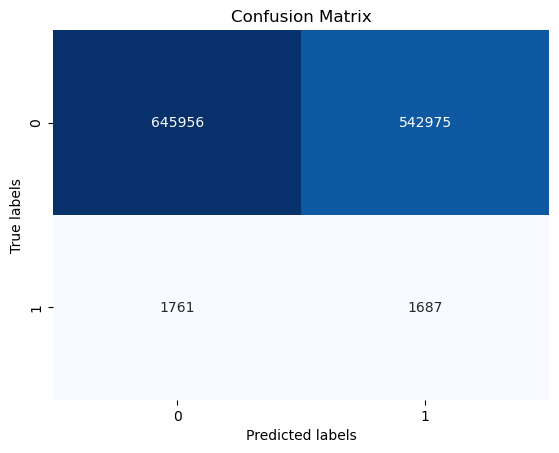

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


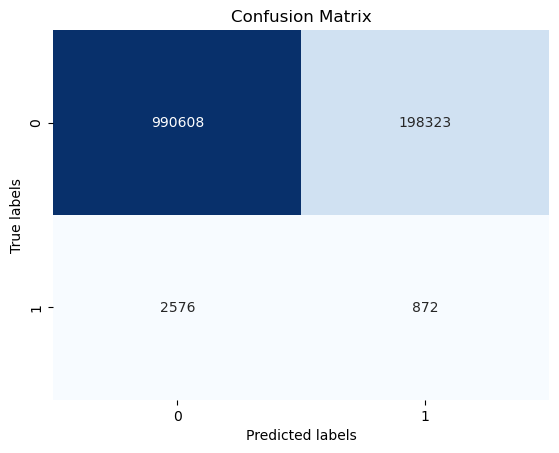

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


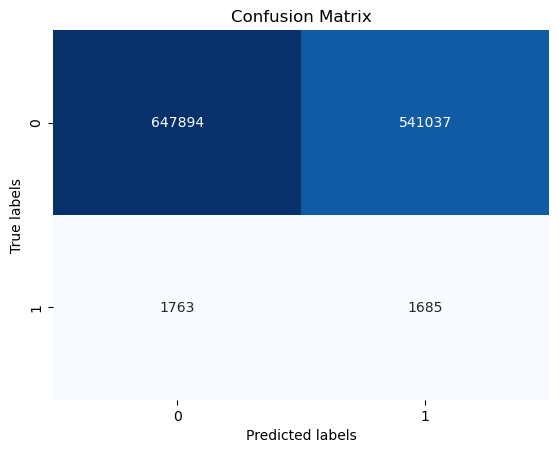

Shift value: -30, Best Training Parameters: {'use_smote': False, 'resample_threshold': 0.2, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.5724755638824816, 'Test Balanced Accuracy': 0.5430462010638382, 'model_choice': 'logistic', 'shuffle': False, 'sort_by': 'date'}
Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Numbe

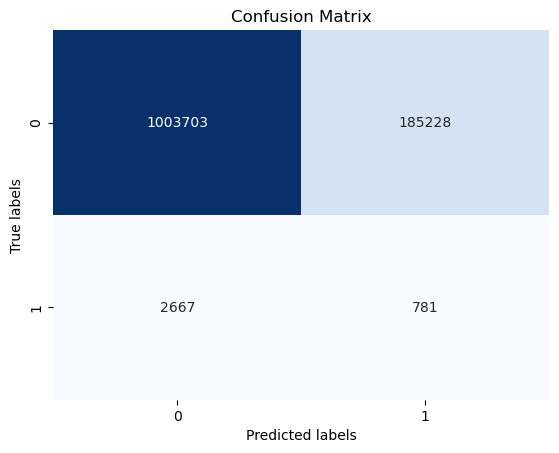

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

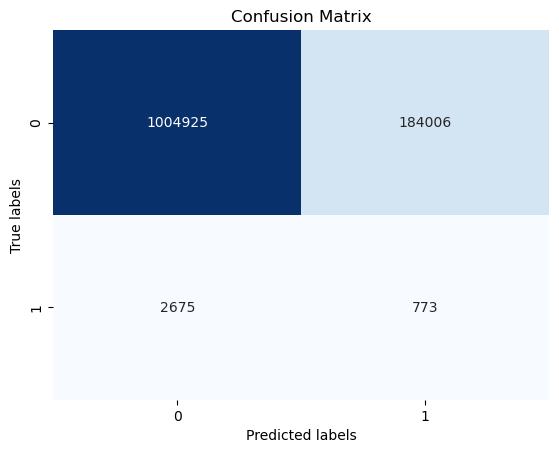

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

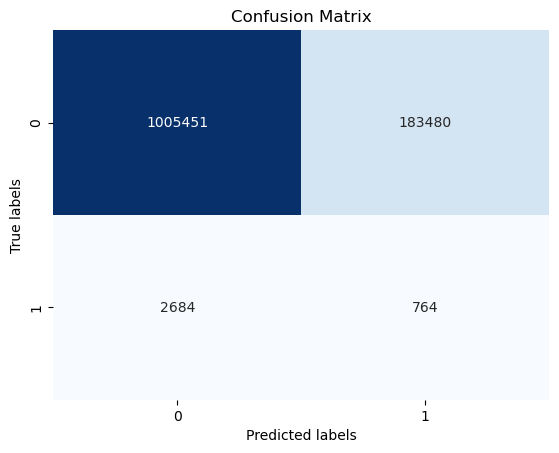

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

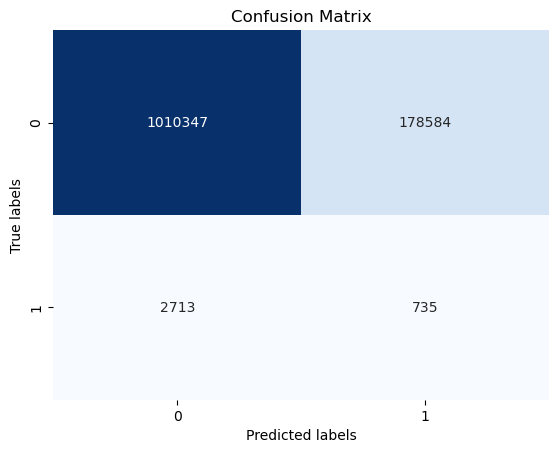

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

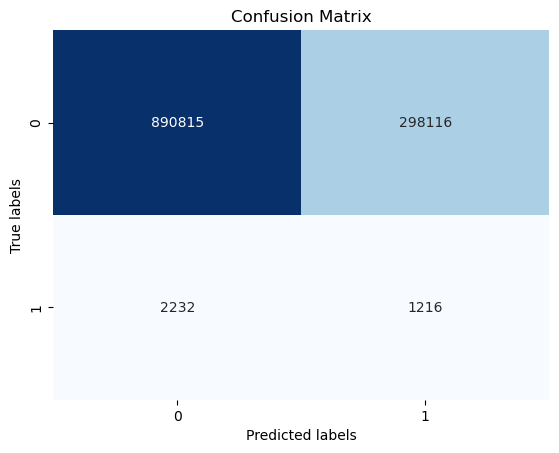

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

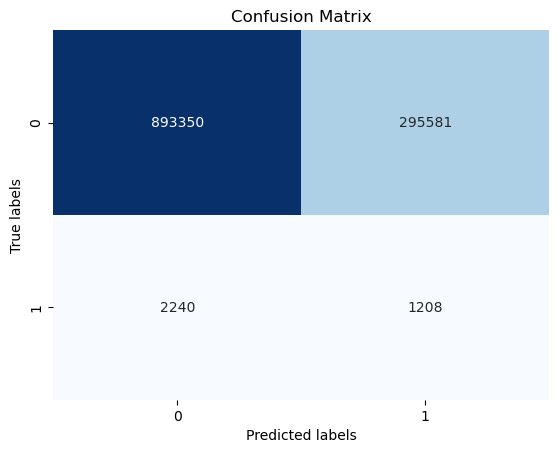

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.310291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

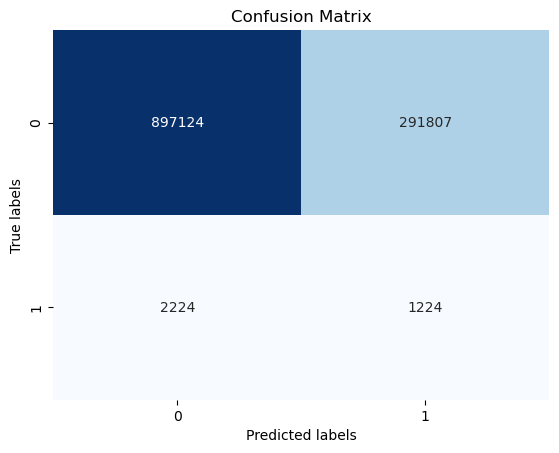

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.308184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

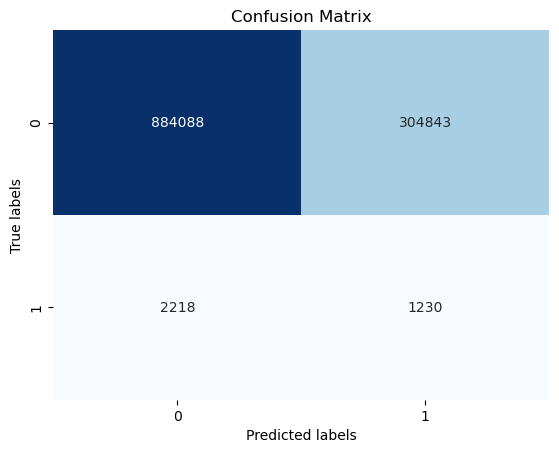

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.1, 'scaling_method': 'minmax', 'Train Balanced Accuracy': 0.7991109477376469, 'Test Balanced Accuracy': 0.534711007530657, 'model_choice': 'lightgbm', 'shuffle': False, 'sort_by': 'date'}


In [26]:
# run_experiment(model_choice,shuffle_bollien,short_bollien)
# Random forest collepses many times : random_forest
# we will do separate set up for that.
models = ['logistic', 'lightgbm']

results_dict_shuffle_False_date = {}

for model in models:

    results_dict_shuffle_False_date[f'results_{model}'] = run_experiment(model, False, 'date')


In [27]:
results_dict_shuffle_False_date

{'results_logistic': {-30: {'use_smote': False,
   'resample_threshold': 0.2,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.5724755638824816,
   'Test Balanced Accuracy': 0.5430462010638382,
   'model_choice': 'logistic',
   'shuffle': False,
   'sort_by': 'date'}},
 'results_lightgbm': {-30: {'use_smote': True,
   'resample_threshold': 0.1,
   'scaling_method': 'minmax',
   'Train Balanced Accuracy': 0.7991109477376469,
   'Test Balanced Accuracy': 0.534711007530657,
   'model_choice': 'lightgbm',
   'shuffle': False,
   'sort_by': 'date'}}}

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


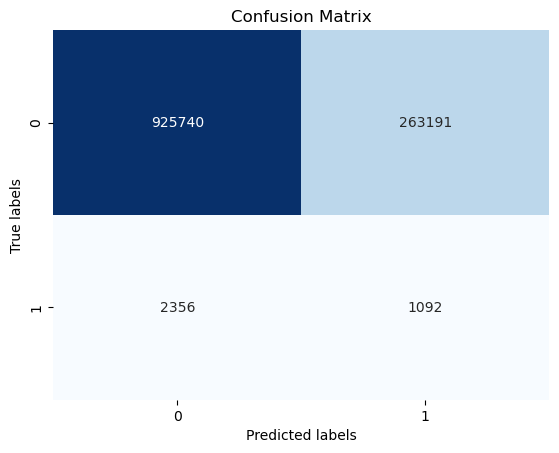

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


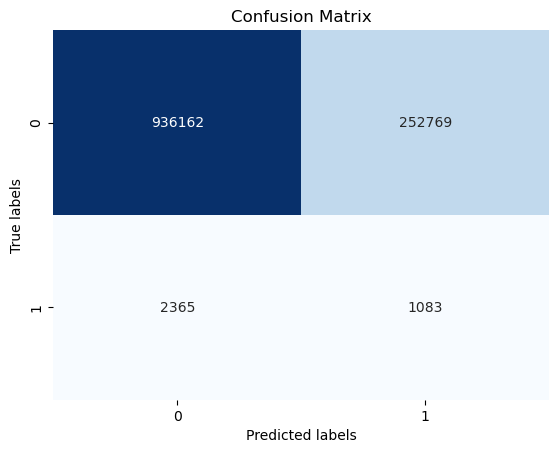

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


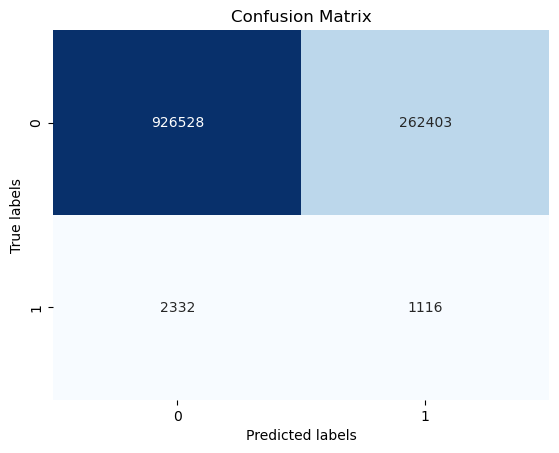

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


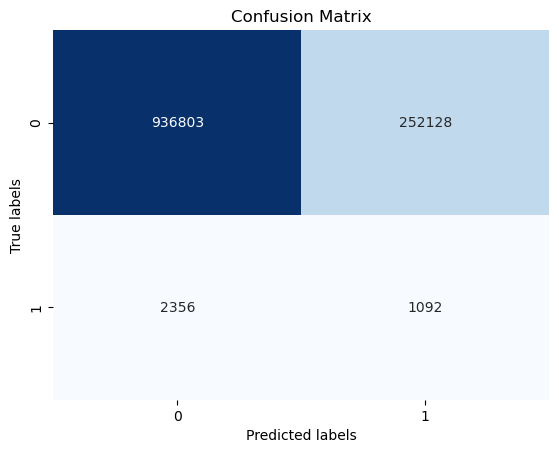

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


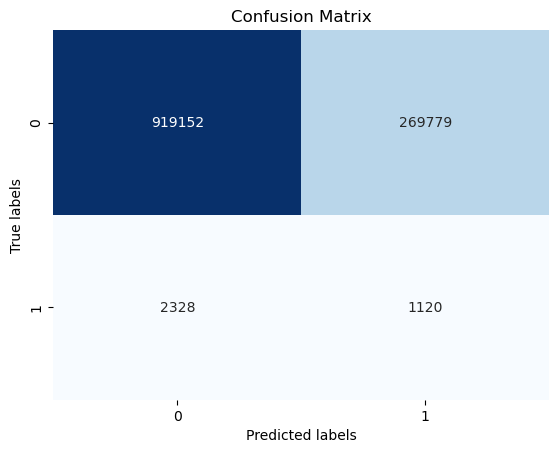

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


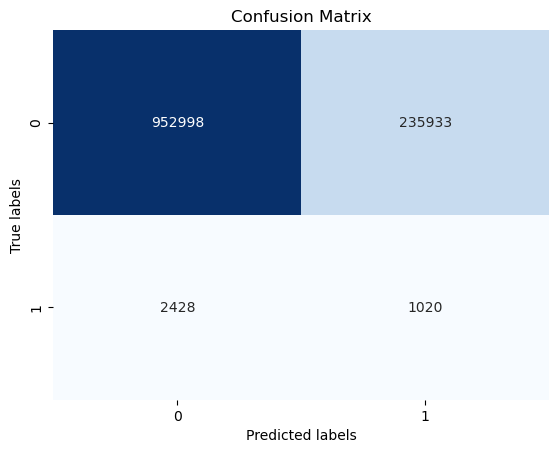

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


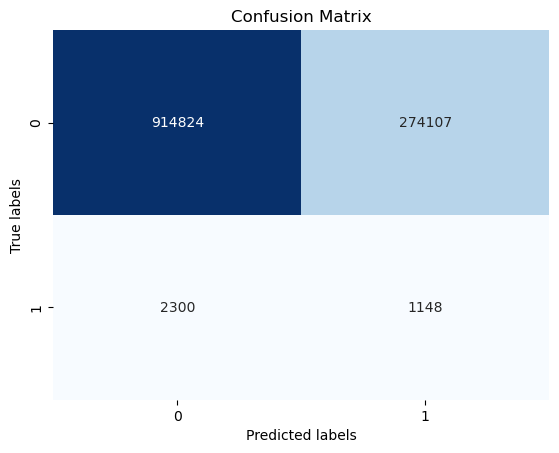

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


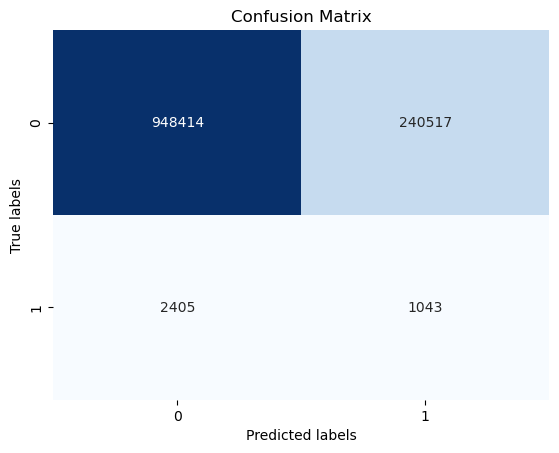

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.2, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.669649778814439, 'Test Balanced Accuracy': 0.5514804535137583, 'model_choice': 'random_forest', 'shuffle': False, 'sort_by': 'date'}


In [28]:
# for RF only
models = ['random_forest']

results_dict_shuffle_False_date_random_forest = {}

for model in models:

    results_dict_shuffle_False_date_random_forest[f'results_{model}'] = run_experiment(model, False, 'date')

In [29]:
results_dict_shuffle_False_date_random_forest

{'results_random_forest': {-30: {'use_smote': True,
   'resample_threshold': 0.2,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.669649778814439,
   'Test Balanced Accuracy': 0.5514804535137583,
   'model_choice': 'random_forest',
   'shuffle': False,
   'sort_by': 'date'}}}

### Shuffle false and date_ticker ordering

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


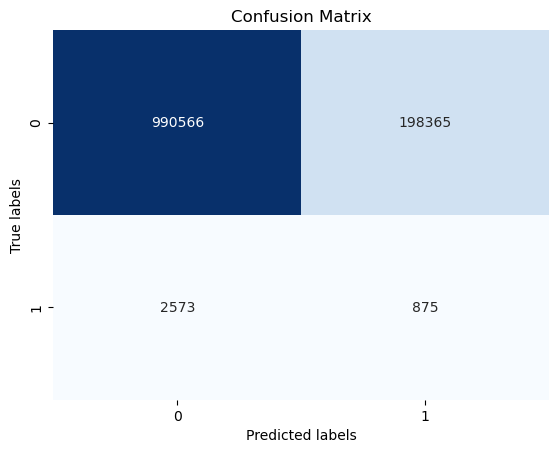

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


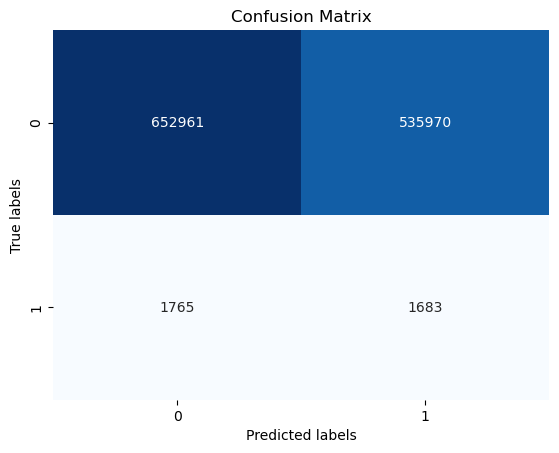

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


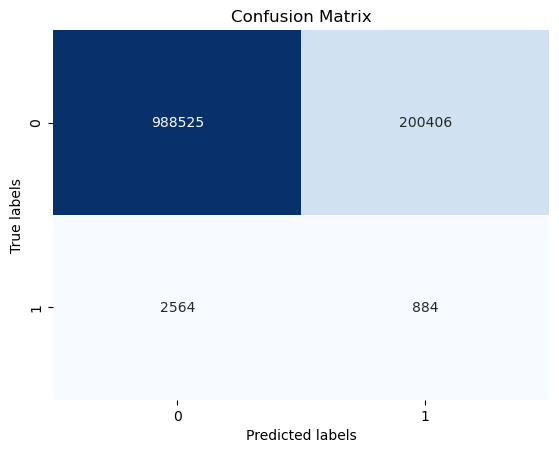

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


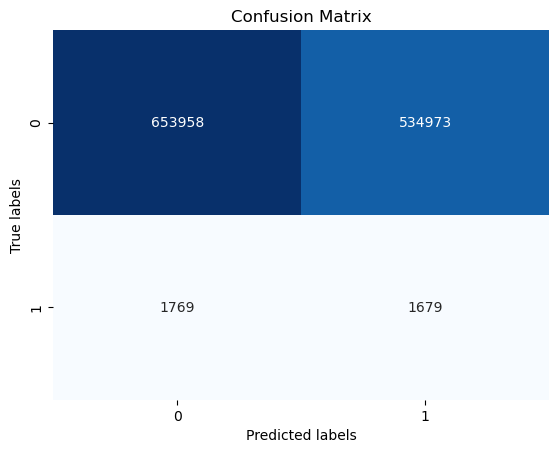

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


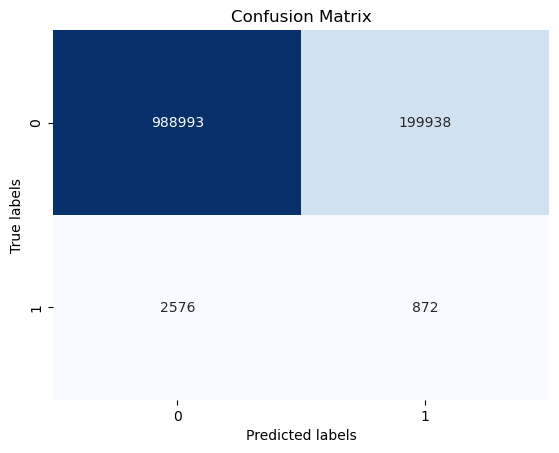

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


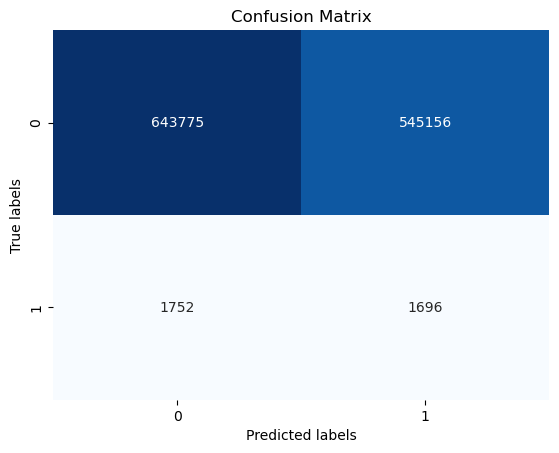

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


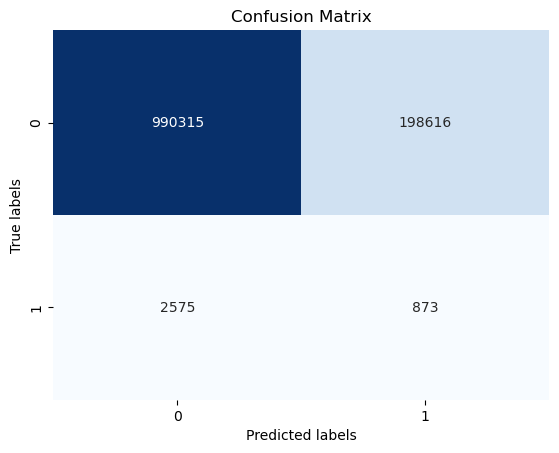

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


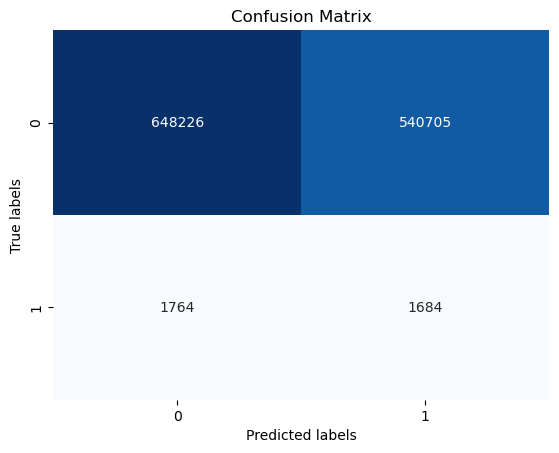

Shift value: -30, Best Training Parameters: {'use_smote': False, 'resample_threshold': 0.1, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.5729466584821616, 'Test Balanced Accuracy': 0.5423670195133529, 'model_choice': 'logistic', 'shuffle': False, 'sort_by': 'index_ticker'}
Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.266063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Inf

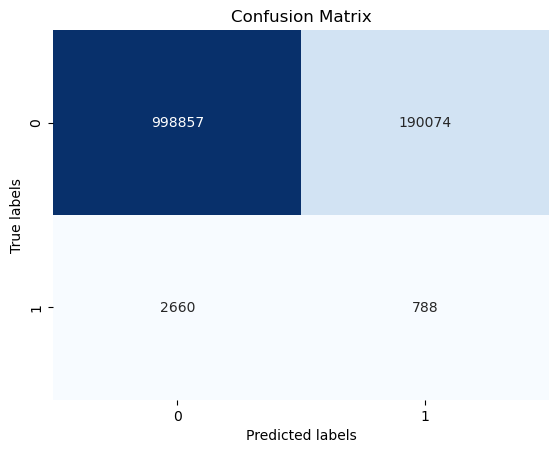

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

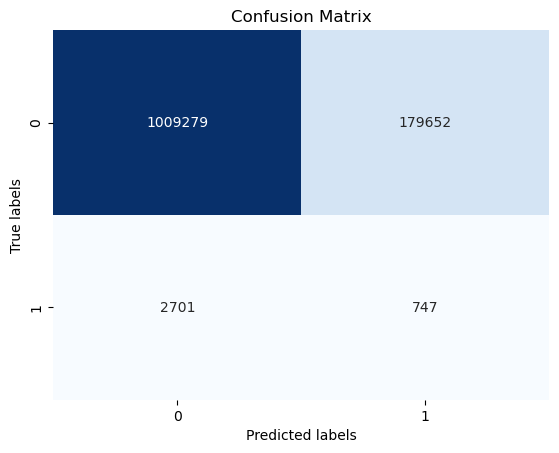

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

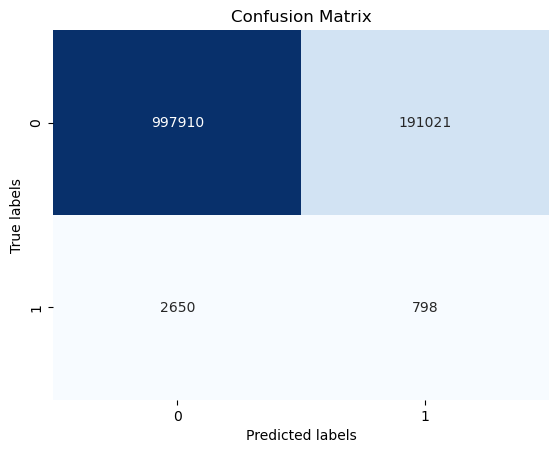

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

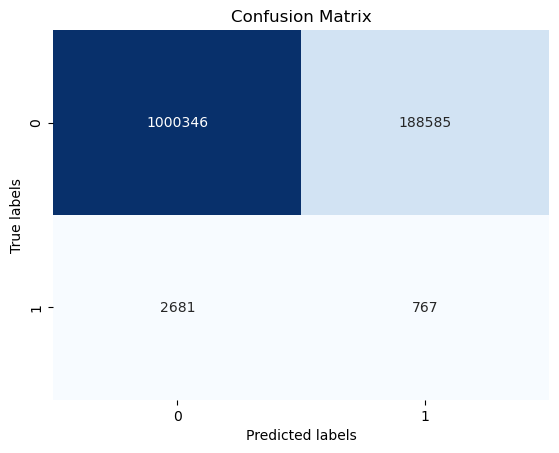

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

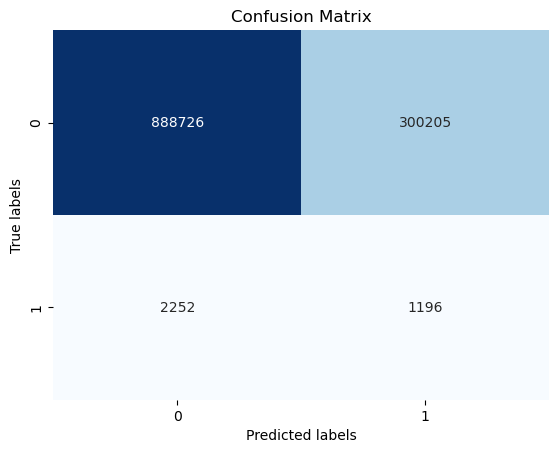

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.271641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

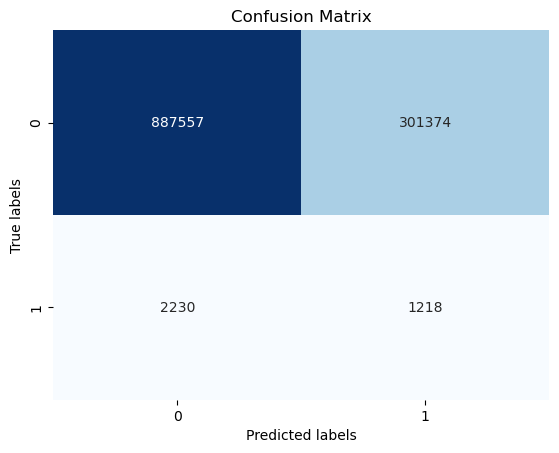

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.297109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

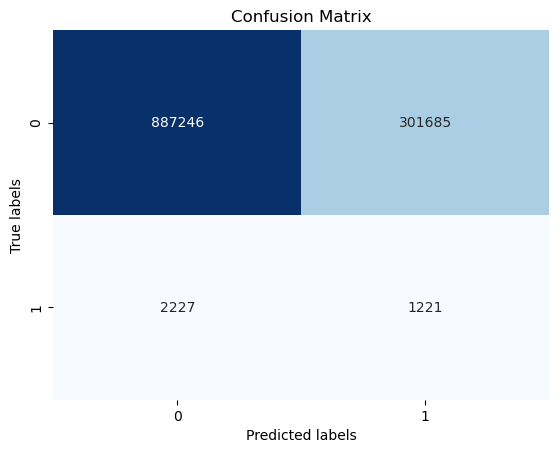

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

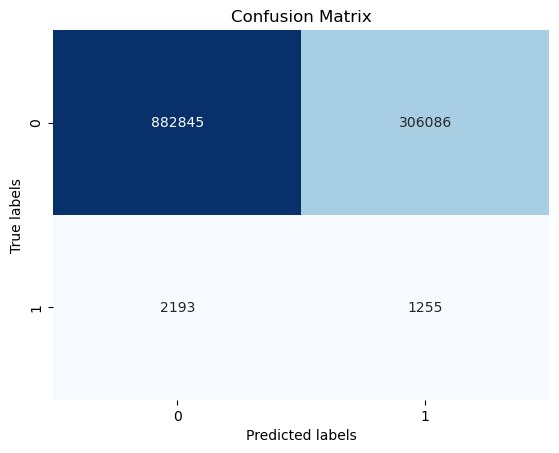

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.1, 'scaling_method': 'minmax', 'Train Balanced Accuracy': 0.797498366090038, 'Test Balanced Accuracy': 0.5327717625448013, 'model_choice': 'lightgbm', 'shuffle': False, 'sort_by': 'index_ticker'}


In [30]:
# Random forest collepses many times : random_forest
# we will do separate set up for that
models = ['logistic', 'lightgbm']

results_dict_shuffle_False_date_ticker = {}

for model in models:

    results_dict_shuffle_False_date_ticker[f'results_{model}'] = run_experiment(model, False, 'index_ticker')

In [31]:
results_dict_shuffle_False_date_ticker

{'results_logistic': {-30: {'use_smote': False,
   'resample_threshold': 0.1,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.5729466584821616,
   'Test Balanced Accuracy': 0.5423670195133529,
   'model_choice': 'logistic',
   'shuffle': False,
   'sort_by': 'index_ticker'}},
 'results_lightgbm': {-30: {'use_smote': True,
   'resample_threshold': 0.1,
   'scaling_method': 'minmax',
   'Train Balanced Accuracy': 0.797498366090038,
   'Test Balanced Accuracy': 0.5327717625448013,
   'model_choice': 'lightgbm',
   'shuffle': False,
   'sort_by': 'index_ticker'}}}

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


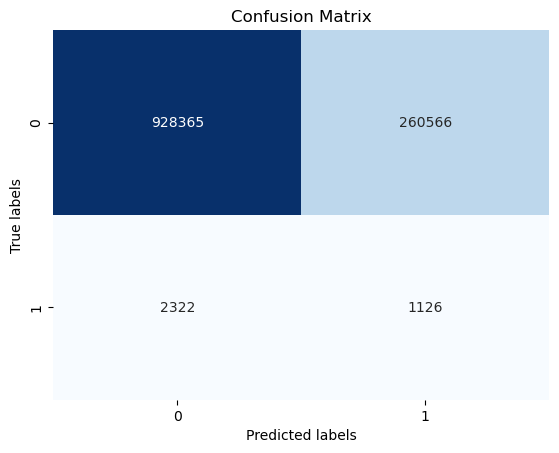

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


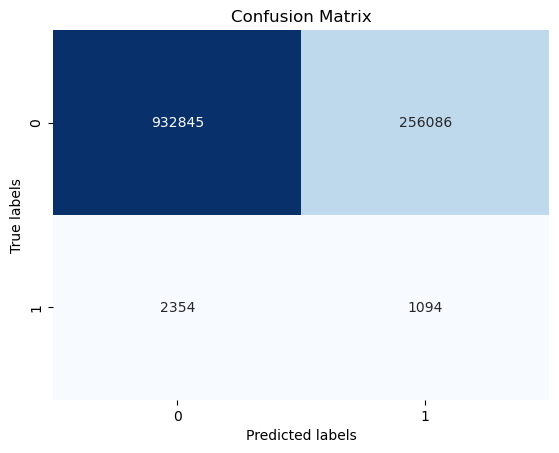

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


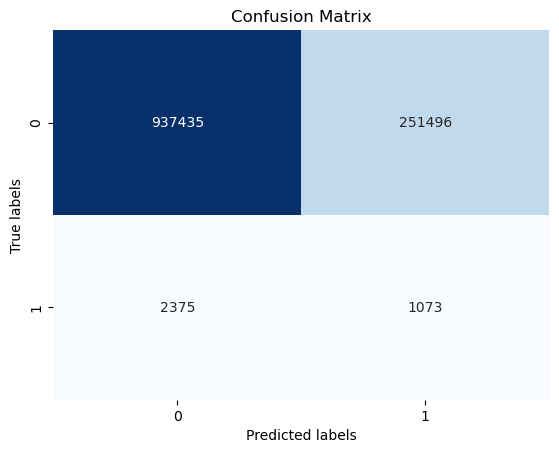

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


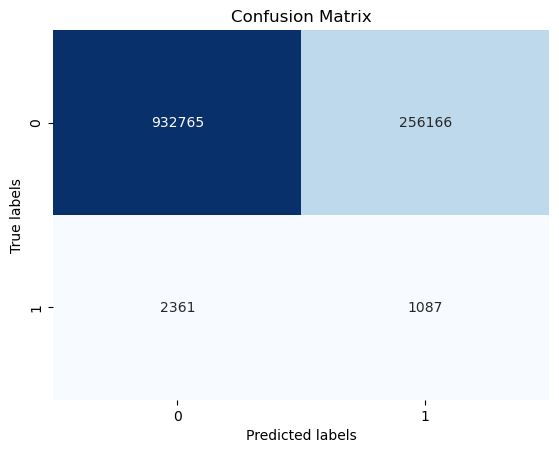

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


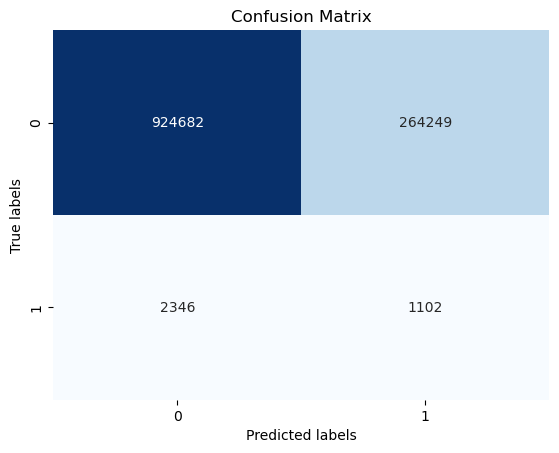

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


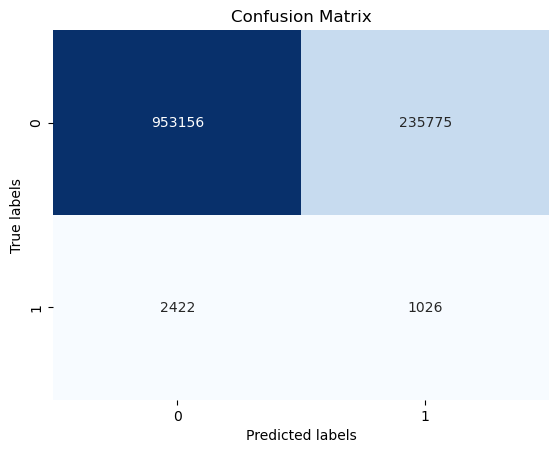

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


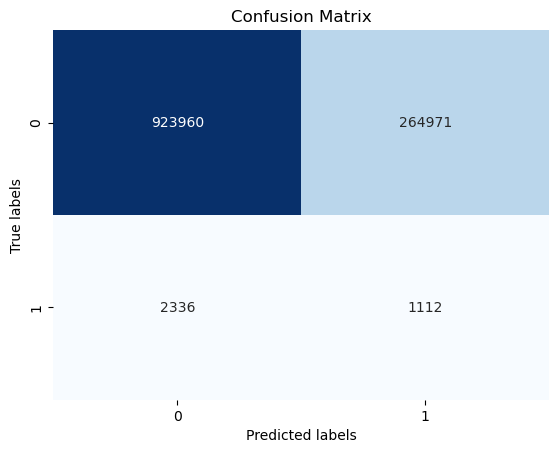

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


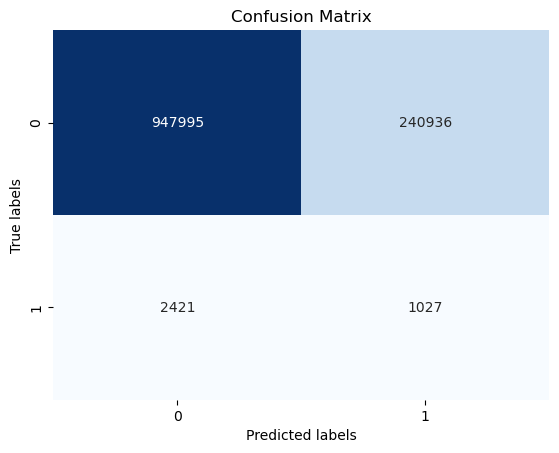

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.1, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.6692251773756175, 'Test Balanced Accuracy': 0.5537031122526003, 'model_choice': 'random_forest', 'shuffle': False, 'sort_by': 'index_ticker'}


In [32]:
models = ['random_forest']

results_dict_shuffle_False_date_ticker_random_forest = {}

for model in models:

    results_dict_shuffle_False_date_ticker_random_forest[f'results_{model}'] = run_experiment(model, False, 'index_ticker')

In [33]:
results_dict_shuffle_False_date_ticker_random_forest

{'results_random_forest': {-30: {'use_smote': True,
   'resample_threshold': 0.1,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.6692251773756175,
   'Test Balanced Accuracy': 0.5537031122526003,
   'model_choice': 'random_forest',
   'shuffle': False,
   'sort_by': 'index_ticker'}}}

### Shuffle True


Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


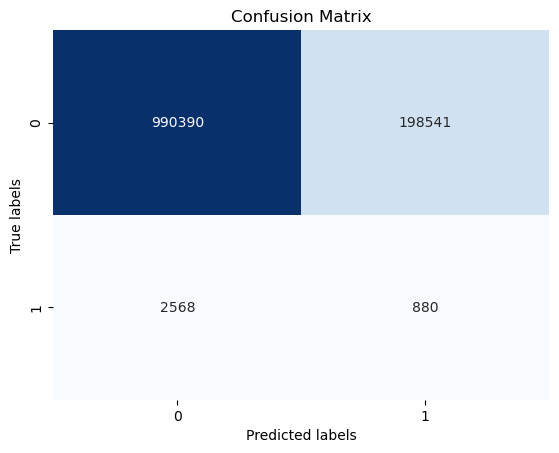

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


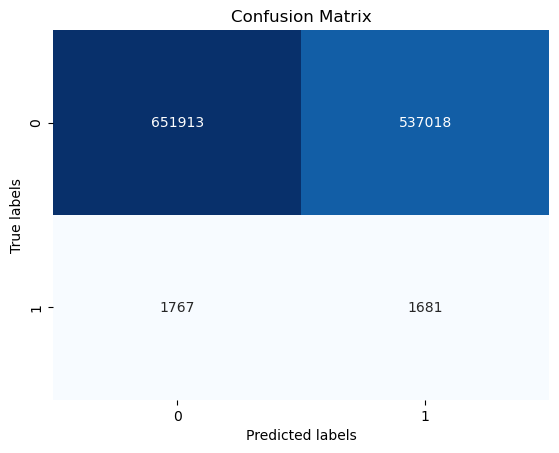

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


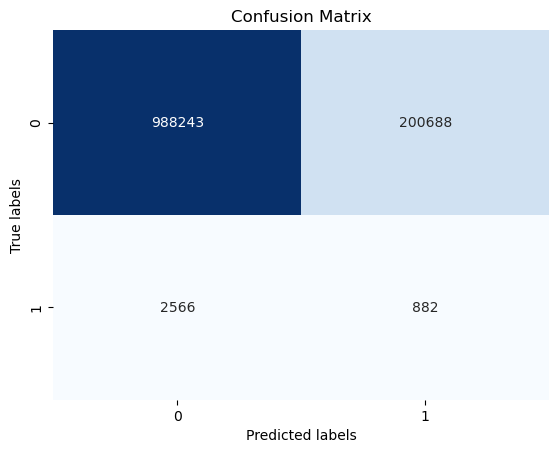

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


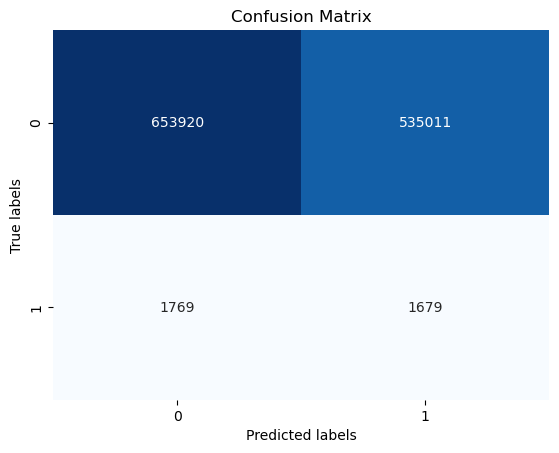

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


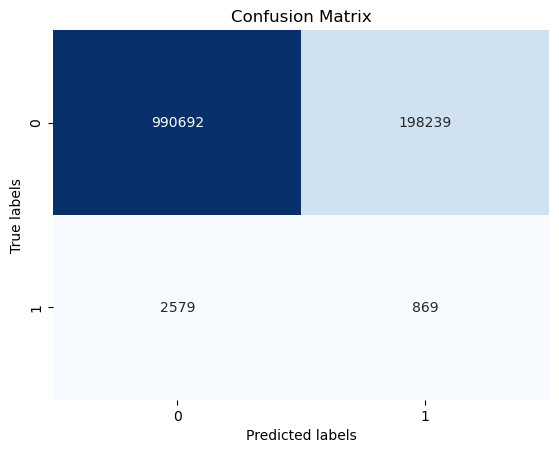

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


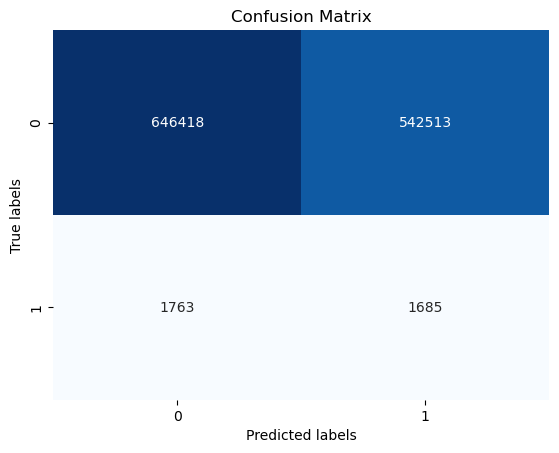

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


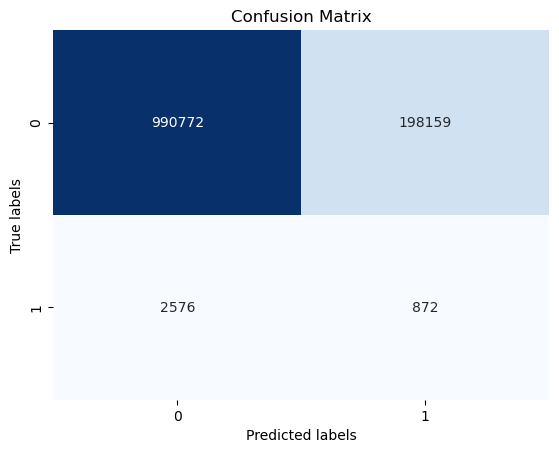

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


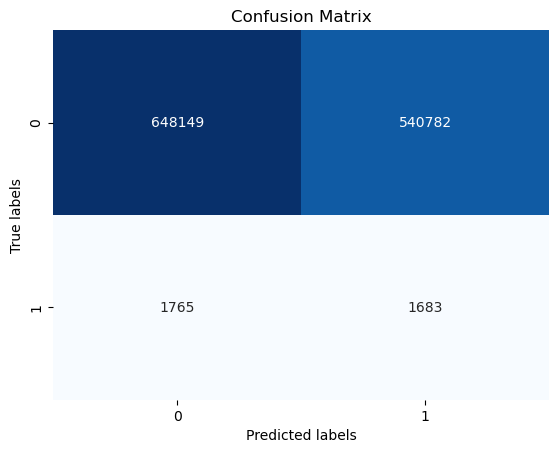

Shift value: -30, Best Training Parameters: {'use_smote': False, 'resample_threshold': 0.1, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.5726873193058473, 'Test Balanced Accuracy': 0.5426464921125962, 'model_choice': 'logistic', 'shuffle': True, 'sort_by': 'date'}
Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.258330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number

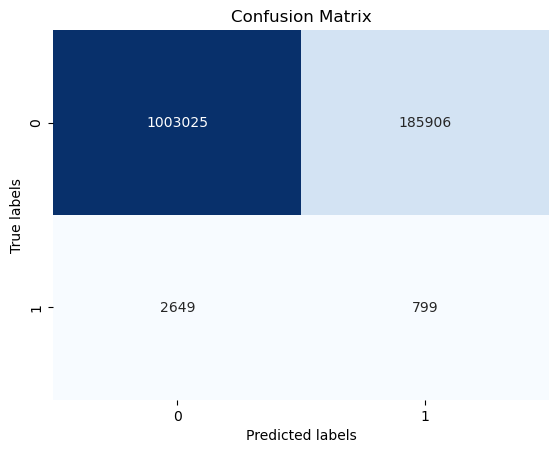

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

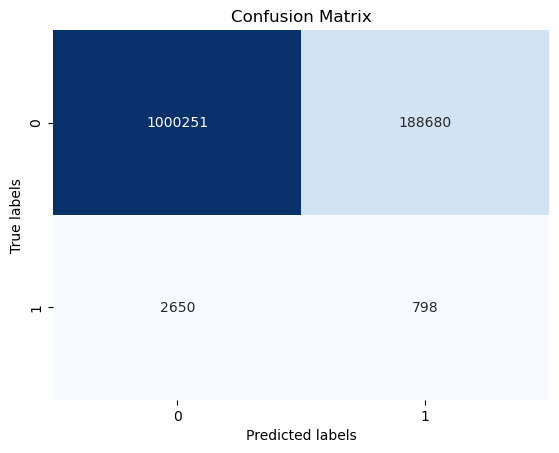

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.336338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

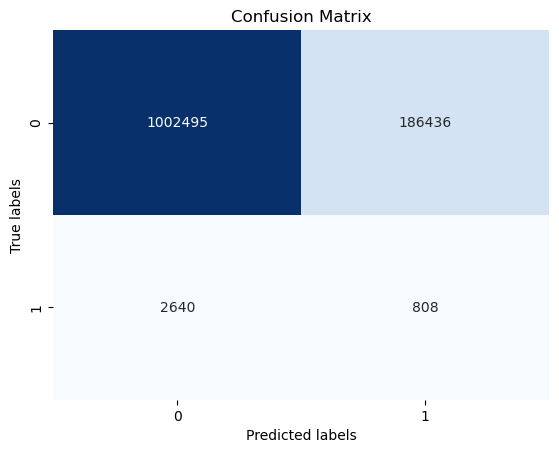

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

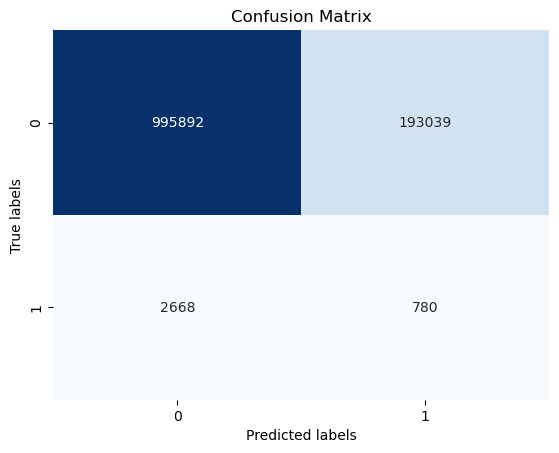

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.289009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

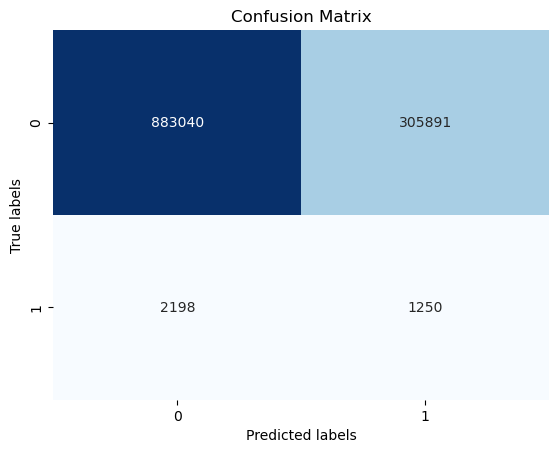

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 277628, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.332630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3053917, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

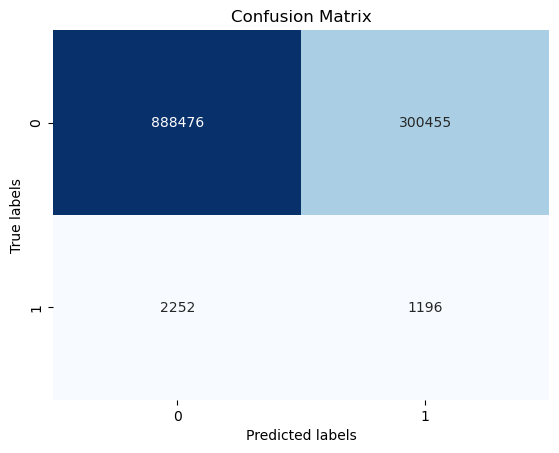

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.293489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

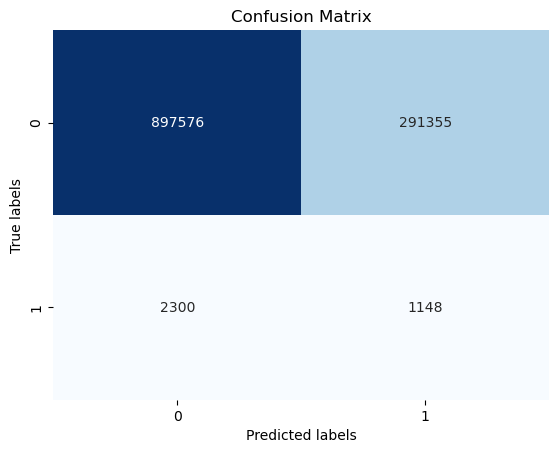

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 555257, number of negative: 2776289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.328024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 3331546, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609439
[LightGBM] [Info] Start training from score -1.609439
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly se

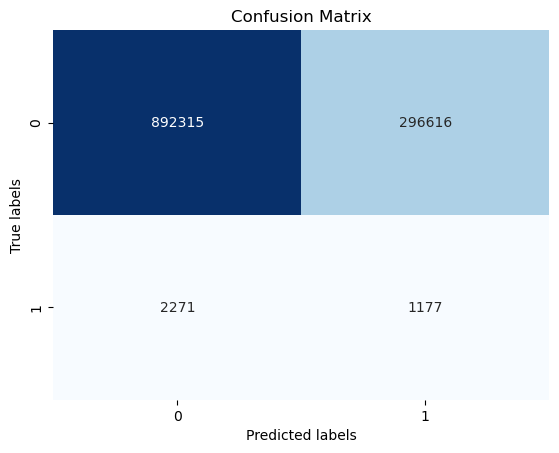

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.2, 'scaling_method': 'minmax', 'Train Balanced Accuracy': 0.7977325257462529, 'Test Balanced Accuracy': 0.5319272980588047, 'model_choice': 'lightgbm', 'shuffle': True, 'sort_by': 'date'}


In [34]:
# Again, we will do differently for Random Forest as we faced with memory issues.
models = ['logistic', 'lightgbm']

results_dict_shuffle_true = {}

for model in models:

    results_dict_shuffle_true[f'results_{model}'] = run_experiment(model, True, 'date') # doesnt matter the input: date or index ticker

In [36]:
results_dict_shuffle_true 

{'results_logistic': {-30: {'use_smote': False,
   'resample_threshold': 0.1,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.5726873193058473,
   'Test Balanced Accuracy': 0.5426464921125962,
   'model_choice': 'logistic',
   'shuffle': True,
   'sort_by': 'date'}},
 'results_lightgbm': {-30: {'use_smote': True,
   'resample_threshold': 0.2,
   'scaling_method': 'minmax',
   'Train Balanced Accuracy': 0.7977325257462529,
   'Test Balanced Accuracy': 0.5319272980588047,
   'model_choice': 'lightgbm',
   'shuffle': True,
   'sort_by': 'date'}}}

### RF only

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


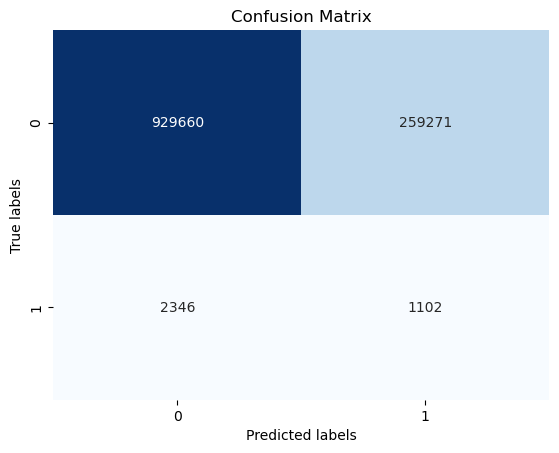

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


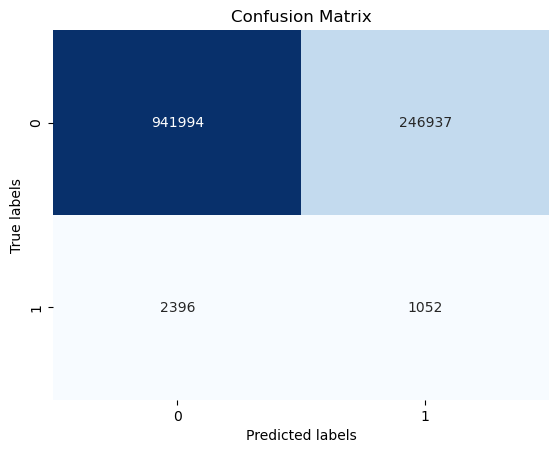

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


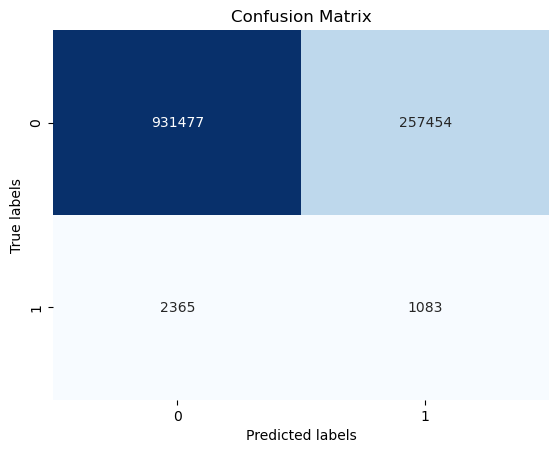

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


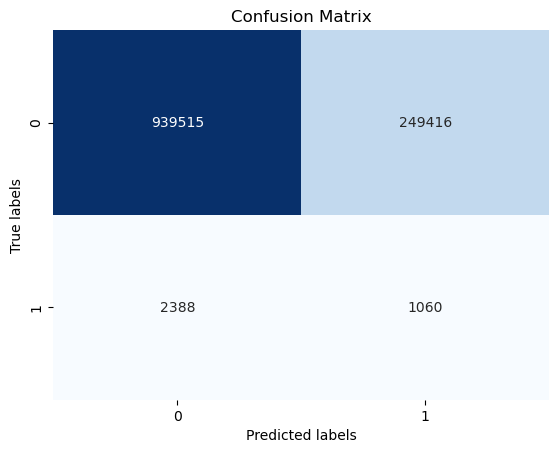

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


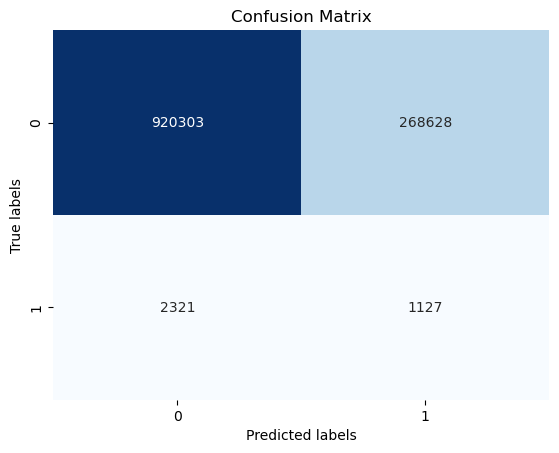

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 277628
Count of label  after resample '0': 2776289


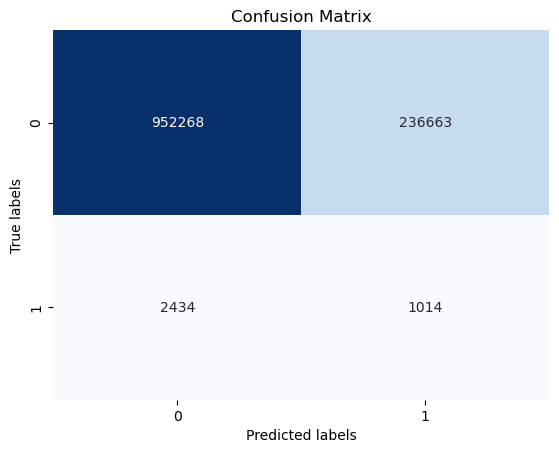

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


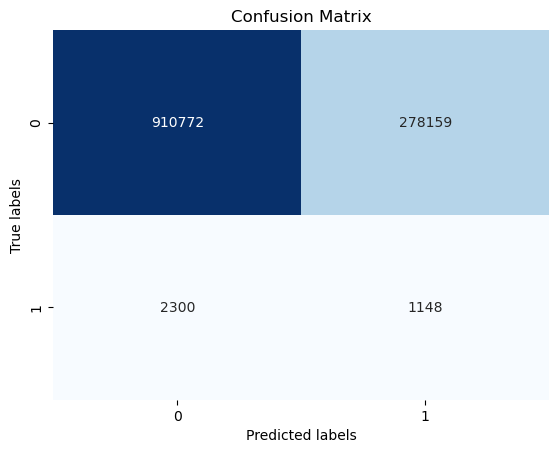

Count of label before resample'1': 5928
Count of label  before resample '0': 2776289
Count of label after resample'1': 555257
Count of label  after resample '0': 2776289


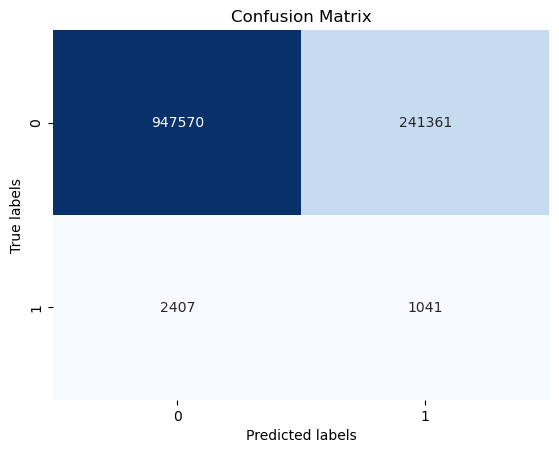

Shift value: -30, Best Training Parameters: {'use_smote': True, 'resample_threshold': 0.2, 'scaling_method': 'power', 'Train Balanced Accuracy': 0.6699174028285324, 'Test Balanced Accuracy': 0.5487763521031638, 'model_choice': 'random_forest', 'shuffle': True, 'sort_by': 'date'}


In [37]:
# we do rf in once here
# shuffle is true
models = ['random_forest']

results_dict_shuffle_true_random_forest = {}

for model in models:

    results_dict_shuffle_true_random_forest[f'results_{model}'] = run_experiment(model, True, 'date')

In [38]:
results_dict_shuffle_true_random_forest

{'results_random_forest': {-30: {'use_smote': True,
   'resample_threshold': 0.2,
   'scaling_method': 'power',
   'Train Balanced Accuracy': 0.6699174028285324,
   'Test Balanced Accuracy': 0.5487763521031638,
   'model_choice': 'random_forest',
   'shuffle': True,
   'sort_by': 'date'}}}

In [ ]:
# We save the Test Balanced Accuracy from each model and put into the table in the thesis.

### For Hyperparameter optimization we will do the following
    1. Separately tune the models by using the time_series_grid_search function
    2. use the default imbalance handling method
    3. Use Impipeline for grid research: scale,rescale,model fit
    4. Save ROC,Confusion matrix, best model and evaulate the grid research via balanced accuracy
 

In [51]:
# https://datascience.stackexchange.com/questions/57924/difference-between-sklearn-make-pipeline-and-imblearn-make-pipeline
# https://stackoverflow.com/questions/67184779/difference-between-imblearn-pipeline-and-pipeline
# https://towardsdatascience.com/enrich-your-train-fold-with-a-custom-sampler-inside-an-imblearn-pipeline-68f6dff964bf
def time_series_grid_search(model_choice, data, n_splits=3, use_smote=True, resample_threshold=0.1, scaling_method='standard',shuffle=False, sort_by=None, output_dir='C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output'):
    import os
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
    from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from lightgbm import LGBMClassifier
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.pipeline import Pipeline as ImPipeline
    import matplotlib.pyplot as plt
    import seaborn as sns
    import joblib
    os.makedirs(output_dir, exist_ok=True)
    
    input_data = data.copy()
    input_data = input_data.sort_index()
    input_data['Final_Target'] = input_data['Final_Target'].astype(int)

    split_index = int(len(input_data) * 0.7)
    train_data = input_data[:split_index]
    test_data = input_data[split_index:]
    if shuffle:
        train_data = train.sample(frac=1)
    else:
        if sort_by == 'date':
             train_data = train_data.sort_index(level=0)
        elif sort_by == 'index_ticker':
            # Sorting by both 'Date' and 'Ticker' indexes
            train_data = train_data.reset_index().sort_values(by=['index', 'Ticker']).set_index('index')
            train_data.index.name = None
    train_data.set_index(['Ticker'], append=True, inplace=True)
    test_data.set_index(['Ticker'], append=True, inplace=True)
    test_index = test_data.index
    
    feature_names = train_data.drop(['Target', 'Quarter', 'Adj Close', 'Final_Target'], axis=1).columns.tolist()
    y_train = train_data['Final_Target']
    y_test = test_data['Final_Target']
    X_train = train_data[feature_names]
    X_test = test_data[feature_names]

    scaler = {'standard': StandardScaler(), 'power': PowerTransformer(), 'minmax': MinMaxScaler()}[scaling_method]
    resampler = SMOTE(sampling_strategy=resample_threshold) if use_smote else RandomOverSampler(sampling_strategy=resample_threshold)

    models = {
        'logistic': LogisticRegression(class_weight='balanced', max_iter=300),
        'random_forest': RandomForestClassifier(class_weight='balanced'),
        'lightgbm': LGBMClassifier(is_unbalance=True)
    }
    param_grids = {
        'logistic': {'model__C': [0.001, 0.01, 0.1],'model__solver': ['liblinear', 'saga']},
        'random_forest': {'model__n_estimators': [100, 75,120], 'model__max_depth': [ 8,10], 'model__min_samples_split': [2,10]},
        'lightgbm': {'model__num_leaves': [31, 40, 50,70], 'model__max_depth': [7, 8, 9,10], 'model__bagging_fraction': [0.8, 0.9, 1],'model__reg_alpha': [0.0, 0.2]}
    }

    pipeline = ImPipeline([
        ('scaler', scaler),
        ('resampler', resampler),
        ('model', models[model_choice])
    ])

    tscv = TimeSeriesSplit(n_splits=n_splits)
    scorer = make_scorer(balanced_accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grids[model_choice], cv=tscv, scoring=scorer, verbose=3)
    grid_search.fit(X_train, y_train)

    # Evaluate the model on the test set
    best_model = grid_search.best_estimator_
    test_preds = best_model.predict(X_test)
    test_pred_probas = best_model.predict_proba(X_test)[:, 1]
    test_score = balanced_accuracy_score(y_test, test_preds)
    cm = confusion_matrix(y_test, test_preds)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_probas, pos_label=1)
    auc_score = auc(fpr, tpr)

    model_filename = os.path.join(output_dir, f"{model_choice}_best_model.joblib")
    joblib.dump(best_model, model_filename)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    roc_curve_filename = os.path.join(output_dir, f"{model_choice}_roc_curve.png")
    plt.savefig(roc_curve_filename)
    plt.close()

    # Save Confusion Matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Best Model')
    confusion_matrix_filename = os.path.join(output_dir, f"{model_choice}_confusion_matrix.png")
    plt.savefig(confusion_matrix_filename)
    plt.close()

    return {
        'Train Balanced Accuracy Score': balanced_accuracy_score(y_train, best_model.predict(X_train)),
        'Best Model Filename': model_filename,
        'Best Score': grid_search.best_score_,
        'Balanced Accuracy Score (Test)': test_score,
        'ROC Curve File': roc_curve_filename,
        'Confusion Matrix File': confusion_matrix_filename,
        'best params':grid_search.best_params_
    }




In [13]:
filtered_datasets[-30].head() # we are using the good data

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,21.688333,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,21.543110,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,21.370333,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,21.168667,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,20.967000,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437


In [14]:
filtered_datasets[-30].tail() # we are using the good data

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2023-11-25,1.436518e+06,-0.027200,False,0.117356,1.468595e+06,0.105797,0.011224,1.488193,0.316211,0.017566,...,124.916833,False,1.398266e+06,122.549308,127.83,YUM,0.21932,126.930333,8.078978e+05,0.070777
2023-11-26,1.417787e+06,-0.075421,False,0.117356,1.463184e+06,0.105797,0.011224,1.421117,0.316211,0.017566,...,125.212833,False,1.352157e+06,122.600846,127.76,YUM,0.21932,127.104553,8.007057e+05,0.070777
2023-11-27,1.413141e+06,-0.119802,False,0.117356,1.463824e+06,0.105797,0.011224,1.346786,0.316211,0.017566,...,125.501723,False,1.321241e+06,122.651462,127.69,YUM,0.21932,127.288333,8.333579e+05,0.070777
2023-11-28,1.411992e+06,-0.237673,False,0.117356,1.464640e+06,0.105797,0.011224,1.169497,0.316211,0.017566,...,125.742500,False,1.307281e+06,122.682231,126.39,YUM,0.21932,127.399667,9.583098e+05,0.070777
2023-11-29,1.405414e+06,-0.367443,False,0.117356,1.464637e+06,0.105797,0.011224,0.947866,0.316211,0.017566,...,125.949500,False,1.296888e+06,122.699769,125.52,YUM,0.21932,127.305667,1.095216e+06,0.070777


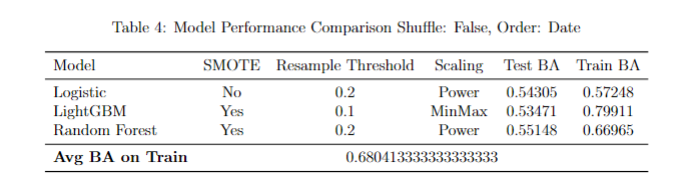

In [43]:
# Instert the above preprocessing parameters
results_logistic_grid = {}
for shift_val, df in filtered_datasets.items():
    summary=time_series_grid_search(model_choice='logistic',data=df,use_smote=False, resample_threshold=0.2, scaling_method='power',shuffle=False,sort_by='date')
    results_logistic_grid['best logistic']=summary


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END model__C=0.001, model__solver=liblinear;, score=0.551 total time=  32.1s
[CV 2/3] END model__C=0.001, model__solver=liblinear;, score=0.537 total time=  56.3s
[CV 3/3] END model__C=0.001, model__solver=liblinear;, score=0.558 total time= 1.5min
[CV 1/3] END model__C=0.001, model__solver=saga;, score=0.549 total time=  34.5s
[CV 2/3] END model__C=0.001, model__solver=saga;, score=0.536 total time= 1.4min
[CV 3/3] END model__C=0.001, model__solver=saga;, score=0.558 total time= 2.3min
[CV 1/3] END model__C=0.01, model__solver=liblinear;, score=0.553 total time=  30.6s
[CV 2/3] END model__C=0.01, model__solver=liblinear;, score=0.533 total time=  58.5s
[CV 3/3] END model__C=0.01, model__solver=liblinear;, score=0.561 total time= 2.4min
[CV 1/3] END .model__C=0.01, model__solver=saga;, score=0.554 total time= 1.3min
[CV 2/3] END .model__C=0.01, model__solver=saga;, score=0.534 total time= 3.4min
[CV 3/3] END .model__C

C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ..model__C=0.1, model__solver=saga;, score=0.559 total time= 3.3min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ..model__C=0.1, model__solver=saga;, score=0.533 total time= 7.1min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ..model__C=0.1, model__solver=saga;, score=0.564 total time=11.1min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [44]:
results_logistic_grid

{'best logistic': {'Train Balanced Accuracy Score': 0.577951101364595,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\logistic_best_model.joblib',
  'Best Score': 0.5517969206337494,
  'Balanced Accuracy Score (Test)': 0.5375035831043223,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\logistic_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\logistic_confusion_matrix.png',
  'best params': {'model__C': 0.1, 'model__solver': 'saga'}}}

In [52]:
results_rf_grid = {}
for shift_val, df in filtered_datasets.items():
    summary=time_series_grid_search(model_choice='random_forest',data=df,use_smote=True, resample_threshold=0.2, scaling_method='power',shuffle=False,sort_by='date')

    results_rf_grid['best rf']=summary



Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.530 total time= 6.5min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.596 total time=13.8min
[CV 3/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.564 total time=21.7min
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.532 total time= 5.0min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.598 total time=11.6min
[CV 3/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.561 total time=21.3min
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=120;, score=0.531 total time=10.2min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=120;, score=0.598 total time=21.6mi

In [53]:
results_rf_grid

{'best rf': {'Train Balanced Accuracy Score': 0.6414486859996917,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\random_forest_best_model.joblib',
  'Best Score': 0.5651247429615825,
  'Balanced Accuracy Score (Test)': 0.5517761056632946,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\random_forest_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\random_forest_confusion_matrix.png',
  'best params': {'model__max_depth': 8,
   'model__min_samples_split': 10,
   'model__n_estimators': 100}}}

In [45]:
results_light_grid = {}
for shift_val, df in filtered_datasets.items():
    summary=time_series_grid_search(model_choice='lightgbm',data=df,use_smote=True, resample_threshold=0.1, scaling_method='minmax',shuffle=False,sort_by='date')
    results_light_grid['best ligth']=summary



Fitting 3 folds for each of 96 candidates, totalling 288 fits
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[L

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 1/3] END model__bagging_fraction=0.8, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.0;, score=0.525 total time=   6.7s
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 3/3] END model__bagging_fraction=0.8, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.0;, score=0.547 total time=  17.7s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.212273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 2/3] END model__bagging_fraction=0.8, model__max_depth=7, model__num_leaves=70, model__reg_alpha=0.2;, score=0.547 total time=  14.9s
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=0.8, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.2;, score=0.558 total time=  10.7s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 1/3] END model__bagging_fraction=0.8, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.0;, score=0.524 total time=   6.5s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 1/3] END model__bagging_fraction=0.8, model__max_depth=8, model__num_leaves=70, model__reg_alpha=0.2;, score=0.516 t

[CV 1/3] END model__bagging_fraction=0.8, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.2;, score=0.526 total time=   6.4s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[Li

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 3/3] END model__bagging_fraction=0.8, model__max_depth=9, model__num_leaves=40, model__reg_alpha=0.2;, score=0.547 total time=  16.4s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2289984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 3/3] END model__bagging_fraction=0.8, model__max_depth=9, model__num_leaves=70, model__reg_alpha=0.0;, score=0.538 total time=  19.6s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] E

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 2/3] END model__bagging_fraction=0.8, model__max_depth=10, model__num_leaves=40, model__reg_alpha=0.2;, score=0.552 total time=  11.7s
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2289984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] 

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[CV 2/3] END model__bagging_fraction=0.8, model__max_depth=10, model__num_leaves=70, model__reg_alpha=0.0;, score=0.552 total time=  13.4s
[LightGBM] 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2289984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.0;, score=0.548 total time=  18.9s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set 

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.2;, score=0.520 total time=   6.1s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[L

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=70, model__reg_alpha=0.0;, score=0.518 total time=   6.5s
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.0;, score=0.555 total time=  11.1s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 2289984, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.2;, score=0.554 total time=  11.9s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.0;, score=0.527 total time=   5.8s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=40, model__reg_alpha=0.0;, score=0.560 total time=  11.3s
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.2;, score=0.522 total time=   6.6s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] E

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=10, model__num_leaves=40, model__reg_alpha=0.0;, score=0.523 total time=   7.3s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] 

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=10, model__num_leaves=50, model__reg_alpha=0.2;, score=0.523 total time=   7.0s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Wa

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=10, model__num_leaves=70, model__reg_alpha=0.2;, score=0.538 total time=  20.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.2;, score=0.556 total time=  15.9s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_f

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.0;, score=0.542 total time=  16.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] No furth

[CV 1/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=70, model__reg_alpha=0.2;, score=0.522 total time=   6.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 2/3] END model__baggin

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.2;, score=0.562 total time=  10.8s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.0;, score=0.527 total time=   6.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] baggi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=70, model__reg_alpha=0.2;, score=0.520 total time=   7.1s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of da

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.2;, score=0.559 total time=  10.8s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.0;, score=0.523 total time=   7.0s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] baggi

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=70, model__reg_alpha=0.2;, score=0.522 total time=   8.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] baggi

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=10, model__num_leaves=31, model__reg_alpha=0.2;, score=0.560 total time=  10.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 208180, number of negative: 2081804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, th

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=10, model__num_leaves=50, model__reg_alpha=0.0;, score=0.520 total time=   6.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 138698, number of negative: 1386980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1525678, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Warning] bagg

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 69394, number of negative: 693942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 763336, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=10, model__num_leaves=70, model__reg_alpha=0.2;, score=0.517 total time=   7.3s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging

In [46]:
results_light_grid

{'best ligth': {'Train Balanced Accuracy Score': 0.5900051193664477,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\lightgbm_best_model.joblib',
  'Best Score': 0.550438003175318,
  'Balanced Accuracy Score (Test)': 0.5316601433792829,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\lightgbm_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/ultimate model output\\lightgbm_confusion_matrix.png',
  'best params': {'model__bagging_fraction': 0.9,
   'model__max_depth': 7,
   'model__num_leaves': 31,
   'model__reg_alpha': 0.2}}}

# Clustering


Use the clustering output from 'DataPrep': 'clusters_best_3_dtw_normalized.pkl'
Tune the model ( hyperparameters only) per groups.

In [123]:
def time_series_grid_search_clusters(model_choice,data, cluster_id, n_splits=3,
                                     output_dir='C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split',
                                     use_smote=True, resample_threshold=0.1, scaling_method='standard',shuffle=False, sort_by='date'):

    import os
    import joblib
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_curve, auc, make_scorer
    from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from lightgbm import LGBMClassifier
    from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.pipeline import Pipeline as ImPipeline

    os.makedirs(output_dir, exist_ok=True)
    
    input_data = data.copy()
    input_data = input_data.sort_index()
    input_data['Final_Target'] = input_data['Final_Target'].astype(int)

    split_index = int(len(input_data) * 0.7)
    train_data = input_data[:split_index]
    test_data = input_data[split_index:]
    if shuffle:
        train_data = train.sample(frac=1)
    else:
        if sort_by == 'date':
             train_data = train_data.sort_index(level=0)
        elif sort_by == 'index_ticker':
            # Sorting by both 'Date' and 'Ticker' indexes
            train_data = train_data.reset_index().sort_values(by=['index', 'Ticker']).set_index('index')
            train_data.index.name = None
    train_data.set_index(['Ticker'], append=True, inplace=True)
    test_data.set_index(['Ticker'], append=True, inplace=True)
    test_index = test_data.index
    
    feature_names = train_data.drop(['Target', 'Quarter', 'Adj Close', 'Final_Target'], axis=1).columns.tolist()
    y_train = train_data['Final_Target']
    y_test = test_data['Final_Target']
    X_train = train_data[feature_names]
    X_test = test_data[feature_names]

    
    scaler = {'standard': StandardScaler(), 'power': PowerTransformer(), 'minmax': MinMaxScaler()}[scaling_method]
    resampler = SMOTE(sampling_strategy=resample_threshold) if use_smote else RandomOverSampler(sampling_strategy=resample_threshold)

    models = {
        'logistic': LogisticRegression(class_weight='balanced', max_iter=300),
        'random_forest': RandomForestClassifier(class_weight='balanced'),
        'lightgbm': LGBMClassifier(is_unbalance=True)
    }

    param_grids = {
        'logistic': {'model__C': [0.001, 0.01, 0.1], 'model__solver': ['liblinear', 'saga']},
        'random_forest': {'model__n_estimators': [100, 75, 120], 'model__max_depth': [8, 10], 'model__min_samples_split': [2, 10]},
        'lightgbm': {'model__num_leaves': [31, 40, 50], 'model__max_depth': [7, 8, 9], 'model__bagging_fraction': [0.9, 1], 'model__reg_alpha': [0.0, 0.2]}
    }

    pipeline = ImPipeline([
        ('scaler', scaler),
        ('resampler', resampler),
        ('model', models[model_choice])
    ])

    tscv = TimeSeriesSplit(n_splits=n_splits)
    scorer = make_scorer(balanced_accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grids[model_choice], cv=tscv, scoring=scorer, verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Save the best model to disk with the model choice and cluster_id
    model_filename = os.path.join(output_dir, f"{model_choice}_cluster_{cluster_id}_best_model.joblib")
    joblib.dump(best_model, model_filename)

    test_preds = best_model.predict(X_test)
    test_pred_probas = best_model.predict_proba(X_test)[:, 1]
    test_score = balanced_accuracy_score(y_test, test_preds)
    cm = confusion_matrix(y_test, test_preds)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred_probas, pos_label=1)
    auc_score = auc(fpr, tpr)

    # Save ROC Curve and Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    roc_curve_filename = os.path.join(output_dir, f"{model_choice}_cluster_{cluster_id}_roc_curve.png")
    plt.savefig(roc_curve_filename)
    plt.close()

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Best Model')
    confusion_matrix_filename = os.path.join(output_dir, f"{model_choice}_cluster_{cluster_id}_confusion_matrix.png")
    plt.savefig(confusion_matrix_filename)
    plt.close()

    return {
        'Train Balanced Accuracy Score': balanced_accuracy_score(y_train, best_model.predict(X_train)),
        'Best Model Filename': model_filename,
        'Best Score': grid_search.best_score_,
        'Balanced Accuracy Score (Test)': test_score,
        'ROC Curve File': roc_curve_filename,
        'Confusion Matrix File': confusion_matrix_filename,
        'best params': grid_search.best_params_
    }


In [ ]:
# I decided not to do here the clustering because it is slower than in visual studio code.
# Lets first decide the chunk point for training

In [29]:
filtered_datasets[-30].head()

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,21.688333,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,21.543110,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,21.370333,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,21.168667,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,20.967000,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437


In [30]:
# we want to use for training and clustering the OHCL data until the main (ohcl +funda) training data cut off point
# it is beneficial as we have more data points there
model_data = filtered_datasets[-30].copy()
model_data = model_data.sort_index()
split_index_model_data = int(len(model_data) * 0.7) # this is the threshold index for training. 
#We will use the exact date from here
train_model_data = model_data[:split_index_model_data]
train_model_data.tail()
#2018-05-24 !!!!

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2018-05-24,1.337800e+05,0.055853,False,-0.191111,1.653412e+05,0.136253,-0.195509,0.454291,-1.407358,-0.197126,...,29.135000,False,1.386933e+05,29.201000,30.17,HNI,-0.770688,30.054000,1.216333e+05,1.753597
2018-05-24,7.489000e+05,-0.010417,False,0.407407,8.829878e+05,-2.923622,-1.264198,0.242901,-1.073137,1.040843,...,29.718667,False,7.165200e+05,29.076308,30.10,WRB,-0.072663,30.034000,6.607050e+05,0.619677
2018-05-24,1.081711e+05,0.013855,False,0.160000,1.259229e+05,-0.587680,0.449477,0.213308,-0.698551,0.403194,...,12.439667,False,1.006267e+05,12.235385,13.13,HVT,-0.077674,12.748667,9.931333e+04,-0.830132
2018-05-24,7.346222e+05,0.015450,False,-0.435953,7.981427e+05,-3.039561,-1.661401,2.321208,-0.053907,-0.072166,...,160.468667,False,8.014500e+05,156.771846,165.44,MCO,0.074684,164.508000,8.600133e+05,0.031978
2018-05-24,2.561058e+06,-0.015111,False,0.095000,2.726243e+06,2.024955,-0.542651,0.348903,-0.352832,-0.272762,...,40.754333,False,2.584360e+06,40.514923,41.43,APH,0.007773,41.580667,1.989347e+06,-0.196247


In [31]:
train_model_data.head()

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2000-04-02,6.216533e+05,0.059731,False,4.928571,6.511908e+05,-4.990699,0.669223,0.084556,0.672430,-1.134135,...,5.254000,False,6.770667e+05,5.492000,5.7033,STZ,-0.172582,5.393780,576960.0,-1.255273
2000-04-02,3.503656e+08,-0.004949,False,0.124722,4.224862e+08,28.299854,-0.821388,0.027509,-0.807598,-0.400258,...,0.975630,False,3.347348e+08,0.907314,1.0167,AAPL,-1.013741,1.023007,358413440.0,-0.398446
2000-04-02,1.462583e+05,-0.033615,False,-0.080357,1.468973e+05,0.858306,-0.903226,0.215999,-1.013353,5.391182,...,12.137000,False,1.059250e+05,11.313462,12.4600,GVA,-0.639274,12.390887,113880.0,154.090179
2000-04-02,5.482122e+05,-0.030955,False,0.195804,5.657100e+05,-0.278651,-0.153074,0.097291,11.577640,0.489343,...,10.760333,False,5.434067e+05,11.217077,11.1433,MOS,0.589823,11.335113,632880.0,-1.162550
2000-04-02,1.534369e+06,-0.031636,False,-0.007634,1.721752e+06,-66.733922,-1.650407,0.033622,-0.758308,-0.970458,...,3.159013,False,1.098353e+06,2.942732,3.0842,HSIC,1.515991,3.224067,919428.0,-0.574394


In [80]:
with open('clusters_best_3_dtw_normalized.pkl', 'rb') as file:
    clusters= pickle.load(file)

pivot_df=pd.read_csv('pivot_df.csv',index_col='Unnamed: 0', parse_dates=True) # from the main visual studio code

In [81]:
# number of groups in ech clusters
groups_clusters=clusters.groupby(['Cluster'])['Ticker'].unique()
for i in groups_clusters:
    print(len(i))

172
95
409


In [82]:
clusters.head()


,Ticker,Open,High,Close,Low,Adj Close,Volume,Cluster
1999-11-25,CNMD,15.3750,15.5800,15.0600,14.8150,12.8050,198300.0,2
1999-11-25,CNP,20.7350,20.8400,20.6800,20.5750,6.9900,384401.0,2
1999-11-25,CNX,4.1797,4.4141,4.3229,4.1797,3.1355,280680.0,1
1999-11-25,COF,46.8450,47.4400,47.1850,46.5000,35.0100,262450.0,0
1999-11-25,COP,18.3700,18.4850,18.2600,18.1900,8.5050,577844.0,0


In [83]:
pivot_df.head()

,A,AA,AAON,AAPL,ABCB,ABM,ABT,ADC,ADM,AEE,...,WTS,WWD,WWW,WY,X,XEL,XOM,XRAY,XRX,YUM
1999-11-28,25.122500,56.827500,0.558450,0.717300,5.765000,6.210000,9.883750,2.952500,6.778750,11.115000,...,10.886250,3.372500,2.596250,9.902500,18.575000,7.348750,18.542500,6.577500,41.755000,5.098750
1999-12-05,26.534286,60.110000,0.561457,0.811700,5.718571,6.057143,9.707143,2.947143,6.612857,11.222857,...,10.087143,3.427143,2.510000,10.471429,20.301429,7.448571,19.311429,6.674286,39.714286,5.121429
1999-12-12,27.477143,64.642857,0.564243,0.814343,5.737143,6.312857,9.098571,2.950000,6.885714,11.032857,...,9.834286,3.491429,2.278571,10.828571,21.590000,7.370000,19.761429,6.515714,34.462857,5.080000
1999-12-19,27.405714,67.168571,0.577314,0.742029,6.055714,6.214286,9.365714,2.881429,6.771429,10.822857,...,10.557143,3.527143,2.437143,11.262857,22.750000,7.278571,19.540000,6.718571,32.394286,4.975714
1999-12-26,29.871429,67.913571,0.614457,0.764700,5.550714,5.971429,9.629286,2.935714,6.470000,11.007143,...,10.464286,3.490000,2.574286,11.455714,23.180714,7.338571,19.443571,6.749286,32.522143,4.848571


In [84]:
clusters.head()

,Ticker,Open,High,Close,Low,Adj Close,Volume,Cluster
1999-11-25,CNMD,15.3750,15.5800,15.0600,14.8150,12.8050,198300.0,2
1999-11-25,CNP,20.7350,20.8400,20.6800,20.5750,6.9900,384401.0,2
1999-11-25,CNX,4.1797,4.4141,4.3229,4.1797,3.1355,280680.0,1
1999-11-25,COF,46.8450,47.4400,47.1850,46.5000,35.0100,262450.0,0
1999-11-25,COP,18.3700,18.4850,18.2600,18.1900,8.5050,577844.0,0


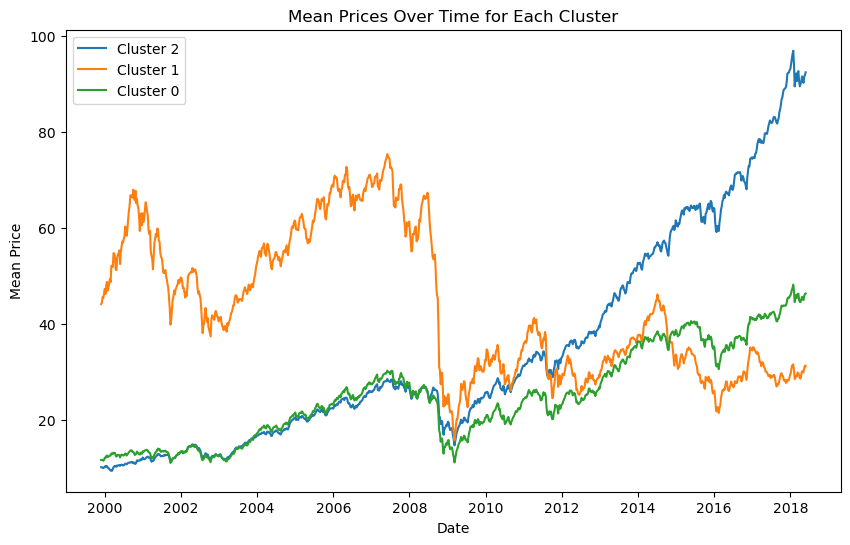

In [85]:

unique_clusters = clusters['Cluster'].unique()

# Plot mean prices for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in unique_clusters:
    tickers_in_cluster = clusters[clusters['Cluster'] == cluster_id]['Ticker'].unique()
    cluster_data = pivot_df[tickers_in_cluster]
    mean_prices = cluster_data.mean(axis=1)
    plt.plot(mean_prices.index, mean_prices, label=f'Cluster {cluster_id}')

plt.title('Mean Prices Over Time for Each Cluster')
plt.xlabel('Date')
plt.ylabel('Mean Price')
plt.legend()
plt.show()

In [77]:
# difference in clusteirng tickers and fundamenta final data
len(clusters.Ticker. unique()),len(filtered_datasets[-30].Ticker. unique())

(676, 645)

In [78]:
# modelling the clusters
clusters.head()

,Ticker,Open,High,Close,Low,Adj Close,Volume,Cluster
1999-11-25,CNMD,15.3750,15.5800,15.0600,14.8150,12.8050,198300.0,2
1999-11-25,CNP,20.7350,20.8400,20.6800,20.5750,6.9900,384401.0,2
1999-11-25,CNX,4.1797,4.4141,4.3229,4.1797,3.1355,280680.0,1
1999-11-25,COF,46.8450,47.4400,47.1850,46.5000,35.0100,262450.0,0
1999-11-25,COP,18.3700,18.4850,18.2600,18.1900,8.5050,577844.0,0


In [86]:
ticker_to_cluster = clusters.set_index('Ticker')['Cluster'].dropna().to_dict()
ticker_to_cluster

{'CNMD': 2,
 'CNP': 2,
 'CNX': 1,
 'COF': 0,
 'COP': 0,
 'COR': 2,
 'CPB': 2,
 'CPE': 1,
 'CPF': 1,
 'CPK': 2,
 'CPT': 2,
 'CR': 2,
 'CRK': 1,
 'CRS': 0,
 'CSL': 2,
 'CSR': 0,
 'CTRA': 0,
 'CTS': 1,
 'CUZ': 1,
 'CVS': 2,
 'CVX': 2,
 'CW': 2,
 'CWT': 2,
 'CXT': 2,
 'CXW': 0,
 'D': 2,
 'DAR': 0,
 'DCI': 2,
 'DD': 2,
 'DDD': 1,
 'DE': 2,
 'DECK': 0,
 'DGX': 2,
 'DHI': 0,
 'DHR': 2,
 'DIN': 0,
 'DINO': 2,
 'DIS': 2,
 'DLX': 2,
 'DOV': 2,
 'DRI': 2,
 'DRQ': 1,
 'DTE': 2,
 'DUK': 2,
 'DVA': 2,
 'DVN': 1,
 'DXC': 2,
 'DY': 0,
 'EAT': 2,
 'ECL': 2,
 'ED': 2,
 'EFX': 2,
 'EG': 2,
 'EGP': 2,
 'EHC': 1,
 'EIX': 2,
 'EL': 2,
 'ELME': 0,
 'ELS': 2,
 'EME': 2,
 'EMN': 2,
 'EMR': 2,
 'EOG': 2,
 'EPR': 2,
 'EQR': 2,
 'EQT': 0,
 'ES': 2,
 'ESE': 0,
 'ESS': 2,
 'ETD': 0,
 'ETN': 2,
 'ETR': 0,
 'EXP': 2,
 'EXPD': 2,
 'F': 1,
 'FBP': 1,
 'FCF': 0,
 'FCN': 0,
 'FCX': 1,
 'FDP': 2,
 'FDS': 2,
 'FDX': 2,
 'FE': 0,
 'FHI': 0,
 'FHN': 1,
 'FI': 2,
 'FICO': 2,
 'FIX': 2,
 'FL': 2,
 'FLO': 2,
 'FLS': 0,
 'FMC': 

In [95]:
# from above take the columns
# we needed to do like this as the jupyter collapsed many times...
columns_to_keep=['45d_rolling_mean_Volume',
 'MACD_H',
 'Target',
 'Return on Invested Capital_RollingPctChangeWindow4',
 '130d_rolling_mean_Volume',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow4',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4',
 'MACD',
 'Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4',
 '5d_rolling_mean_Adj Close',
 'Quarter',
 'Price-to-Free-Cash-Flow_RollingPctChangeWindow2',
 '130d_rolling_mean_Adj Close',
 '45d_rolling_mean_Adj Close',
 'Interest Coverage Ratio_RollingPctChangeWindow4',
 'Price-to-Earnings-Growth_RollingPctChangeWindow4',
 'Operating Margin_RollingPctChangeWindow2',
 'MACD_S',
 '65d_rolling_mean_Volume',
 'RSI',
 '30d_rolling_mean_Adj Close',
 'Final_Target',
 '30d_rolling_mean_Volume',
 '65d_rolling_mean_Adj Close',
 'Adj Close',
 'Ticker',
 'Interest Coverage Ratio_RollingPctChangeWindow2',
 '15d_rolling_mean_Adj Close',
 '5d_rolling_mean_Volume',
 'Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2']

In [96]:
len(set(columns_to_keep))

31

In [97]:
df = filtered_datasets[-30]
df=df[columns_to_keep]
df.head()

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,30d_rolling_mean_Adj Close,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,21.688333,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,21.543110,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,21.370333,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,21.168667,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,20.967000,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437


In [98]:
df['Cluster'] = df['Ticker'].map(ticker_to_cluster)
df.head()

C:\Users\Attila\AppData\Local\Temp\ipykernel_156\2250850818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = df['Ticker'].map(ticker_to_cluster)


,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2,Cluster
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437,0
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437,0
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437,0
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437,0
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437,0


In [100]:
# Check some whether we did right
# 'CNMD': 2,
# 'CNP': 2,
#'CNX': 1,
# 'COF': 0,
# everything ok
df[df['Ticker']=='CNX']['Cluster']

2000-07-01    1
2000-07-02    1
2000-07-03    1
2000-07-04    1
2000-07-05    1
             ..
2023-11-25    1
2023-11-26    1
2023-11-27    1
2023-11-28    1
2023-11-29    1
Name: Cluster, Length: 8462, dtype: int64

In [101]:
len(df),len(shifted_datasets[-30]),len(df.columns) # ok so everything is ok

(3974596, 3974596, 32)

In [66]:
# we will not optimize the model for each time series cause of the limitation of master thesis
# we do an exploration and check whether we should continue the tunning by comparing with the so far best model

In [102]:
df.head() # we have cluster as additional column!

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2,Cluster
2001-04-01,4.299294e+06,-0.175413,False,-0.094595,3.716786e+06,-1.248106,-1.405263,-1.277191,-3.686047,1.461599,...,False,3.834677e+06,25.496615,18.6933,A,4.057935,20.856447,5.455192e+06,-1.825437,0
2001-04-02,4.266124e+06,-0.159657,False,-0.094595,3.722978e+06,-1.248106,-1.405263,-1.301350,-3.686047,1.461599,...,False,3.852904e+06,25.275385,18.7200,A,4.057935,20.638667,5.305913e+06,-1.825437,0
2001-04-03,4.260393e+06,-0.183334,False,-0.094595,3.748642e+06,-1.248106,-1.405263,-1.370860,-3.686047,1.461599,...,False,3.939024e+06,25.042154,17.9000,A,4.057935,20.336000,4.573976e+06,-1.825437,0
2001-04-04,4.198017e+06,-0.232620,False,-0.094595,3.754078e+06,-1.248106,-1.405263,-1.478302,-3.686047,1.461599,...,False,3.966914e+06,24.796308,17.0400,A,4.057935,20.084667,4.071675e+06,-1.825437,0
2001-04-05,4.138869e+06,-0.141682,False,-0.094595,3.760011e+06,-1.248106,-1.405263,-1.422784,-3.686047,1.461599,...,False,3.954005e+06,24.571077,18.5800,A,4.057935,20.045333,3.790127e+06,-1.825437,0


In [119]:
results_logistic_default_compare = {}

for cluster in df['Cluster'].unique():
    print(cluster)
    cluster_data = df[df['Cluster'] == cluster].copy()
    cluster_data.drop(columns=['Cluster'], inplace=True)
    
    # Proceed with preprocessing and model training
    summary= time_series_grid_search_clusters('logistic',data=cluster_data,use_smote=False,cluster_id=cluster, resample_threshold=0.2, scaling_method='power',shuffle=False,sort_by='date')
    
    # Store results keyed by cluster
    results_logistic_default_compare[cluster] = (summary)

0
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END model__C=0.001, model__solver=liblinear;, score=0.545 total time=   8.2s
[CV 2/3] END model__C=0.001, model__solver=liblinear;, score=0.499 total time=  17.6s
[CV 3/3] END model__C=0.001, model__solver=liblinear;, score=0.516 total time=  31.9s
[CV 1/3] END model__C=0.001, model__solver=saga;, score=0.548 total time=   9.7s
[CV 2/3] END model__C=0.001, model__solver=saga;, score=0.495 total time=  18.9s
[CV 3/3] END model__C=0.001, model__solver=saga;, score=0.518 total time=  30.1s
[CV 1/3] END model__C=0.01, model__solver=liblinear;, score=0.553 total time=   7.8s
[CV 2/3] END model__C=0.01, model__solver=liblinear;, score=0.483 total time=  19.6s
[CV 3/3] END model__C=0.01, model__solver=liblinear;, score=0.520 total time=  34.5s
[CV 1/3] END .model__C=0.01, model__solver=saga;, score=0.560 total time=  14.6s
[CV 2/3] END .model__C=0.01, model__solver=saga;, score=0.485 total time=  44.1s
[CV 3/3] END .model_

C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ..model__C=0.1, model__solver=saga;, score=0.484 total time= 2.0min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ..model__C=0.1, model__solver=saga;, score=0.523 total time= 3.1min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


1
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END model__C=0.001, model__solver=liblinear;, score=0.516 total time=   4.9s
[CV 2/3] END model__C=0.001, model__solver=liblinear;, score=0.525 total time=  10.9s
[CV 3/3] END model__C=0.001, model__solver=liblinear;, score=0.536 total time=  15.4s
[CV 1/3] END model__C=0.001, model__solver=saga;, score=0.524 total time=  11.8s
[CV 2/3] END model__C=0.001, model__solver=saga;, score=0.532 total time=  13.5s
[CV 3/3] END model__C=0.001, model__solver=saga;, score=0.530 total time=  21.8s
[CV 1/3] END model__C=0.01, model__solver=liblinear;, score=0.528 total time=   5.4s
[CV 2/3] END model__C=0.01, model__solver=liblinear;, score=0.532 total time=  12.4s
[CV 3/3] END model__C=0.01, model__solver=liblinear;, score=0.538 total time=  18.4s
[CV 1/3] END .model__C=0.01, model__solver=saga;, score=0.532 total time=  14.6s
[CV 2/3] END .model__C=0.01, model__solver=saga;, score=0.531 total time=  22.2s
[CV 3/3] END .model_

C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END ..model__C=0.1, model__solver=saga;, score=0.527 total time= 2.8min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END ..model__C=0.1, model__solver=saga;, score=0.525 total time= 5.7min


C:\Users\Attila\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END ..model__C=0.1, model__solver=saga;, score=0.525 total time= 8.2min


In [120]:
results_logistic_default_compare

{0: {'Train Balanced Accuracy Score': 0.5612524882893979,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\logistic_cluster_0_best_model.joblib',
  'Best Score': 0.5243019657202826,
  'Balanced Accuracy Score (Test)': 0.5197669645976497,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\logistic_cluster_0_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\logistic_cluster_0_confusion_matrix.png',
  'best params': {'model__C': 0.1, 'model__solver': 'saga'}},
 1: {'Train Balanced Accuracy Score': 0.5538561505402132,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\logistic_cluster_1_best_model.joblib',
  'Best Score': 0.534613407390569,
  'Balanced Accuracy Score (Test)': 0.5162324337975563,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Maste

In [122]:
df.tail()

,45d_rolling_mean_Volume,MACD_H,Target,Return on Invested Capital_RollingPctChangeWindow4,130d_rolling_mean_Volume,Price-to-Free-Cash-Flow_RollingPctChangeWindow4,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow4,MACD,Operating Cash Flow to Sales Ratio_RollingPctChangeWindow2,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow4,...,Final_Target,30d_rolling_mean_Volume,65d_rolling_mean_Adj Close,Adj Close,Ticker,Interest Coverage Ratio_RollingPctChangeWindow2,15d_rolling_mean_Adj Close,5d_rolling_mean_Volume,Free Cash Flow to Operating Cash Flow Ratio_RollingPctChangeWindow2,Cluster
2023-11-25,1.436518e+06,-0.027200,False,0.117356,1.468595e+06,0.105797,0.011224,1.488193,0.316211,0.017566,...,False,1.398266e+06,122.549308,127.83,YUM,0.21932,126.930333,8.078978e+05,0.070777,2
2023-11-26,1.417787e+06,-0.075421,False,0.117356,1.463184e+06,0.105797,0.011224,1.421117,0.316211,0.017566,...,False,1.352157e+06,122.600846,127.76,YUM,0.21932,127.104553,8.007057e+05,0.070777,2
2023-11-27,1.413141e+06,-0.119802,False,0.117356,1.463824e+06,0.105797,0.011224,1.346786,0.316211,0.017566,...,False,1.321241e+06,122.651462,127.69,YUM,0.21932,127.288333,8.333579e+05,0.070777,2
2023-11-28,1.411992e+06,-0.237673,False,0.117356,1.464640e+06,0.105797,0.011224,1.169497,0.316211,0.017566,...,False,1.307281e+06,122.682231,126.39,YUM,0.21932,127.399667,9.583098e+05,0.070777,2
2023-11-29,1.405414e+06,-0.367443,False,0.117356,1.464637e+06,0.105797,0.011224,0.947866,0.316211,0.017566,...,False,1.296888e+06,122.699769,125.52,YUM,0.21932,127.305667,1.095216e+06,0.070777,2


In [124]:
# RF default smote false,threshold 0.1, power
results_rf_default_compare = {}

for cluster in df['Cluster'].unique():
    print(cluster)
    cluster_data = df[df['Cluster'] == cluster].copy()
    cluster_data.drop(columns=['Cluster'], inplace=True)
    
    # Proceed with preprocessing and model training
    summary= time_series_grid_search_clusters('random_forest',data=cluster_data,use_smote=True,cluster_id=cluster, resample_threshold=0.2, scaling_method='power',shuffle=False,sort_by='date')

    # Store results keyed by cluster
    results_rf_default_compare[cluster] = (summary)

0
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.527 total time= 1.7min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.565 total time= 3.8min
[CV 3/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.520 total time= 4.5min
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.534 total time=  59.0s
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.567 total time= 2.2min
[CV 3/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.517 total time= 3.5min
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=120;, score=0.528 total time= 1.6min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=120;, score=0.565 total time= 3.5

[CV 1/3] END model__max_depth=10, model__min_samples_split=10, model__n_estimators=120;, score=0.498 total time=  54.1s
[CV 2/3] END model__max_depth=10, model__min_samples_split=10, model__n_estimators=120;, score=0.523 total time= 2.0min
[CV 3/3] END model__max_depth=10, model__min_samples_split=10, model__n_estimators=120;, score=0.533 total time= 3.8min
2
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.524 total time= 4.6min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.555 total time= 9.9min
[CV 3/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=100;, score=0.510 total time=14.2min
[CV 1/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.524 total time= 2.7min
[CV 2/3] END model__max_depth=8, model__min_samples_split=2, model__n_estimators=75;, score=0.552 total ti

In [125]:
results_rf_default_compare

{0: {'Train Balanced Accuracy Score': 0.6579346414424172,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\random_forest_cluster_0_best_model.joblib',
  'Best Score': 0.5391734005144581,
  'Balanced Accuracy Score (Test)': 0.5215647652853186,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\random_forest_cluster_0_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\random_forest_cluster_0_confusion_matrix.png',
  'best params': {'model__max_depth': 8,
   'model__min_samples_split': 2,
   'model__n_estimators': 75}},
 1: {'Train Balanced Accuracy Score': 0.6977779260749954,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\random_forest_cluster_1_best_model.joblib',
  'Best Score': 0.5259013235065764,
  'Balanced Accuracy Score (Test)': 0.5366329

In [126]:
results_light_default_compare = {}

for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster].copy()
    cluster_data.drop(columns=['Cluster'], inplace=True)
    
    summary= time_series_grid_search_clusters('lightgbm',data=cluster_data,use_smote=True,cluster_id=cluster, resample_threshold=0.1, scaling_method='minmax',shuffle=False,sort_by='date')

    # Store results keyed by cluster
    results_light_default_compare[cluster] = (summary)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 189667, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302614
[L

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.2;, score=0.505 total time=   3.7s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 189667, number of used features: 26
[LightGBM] [Info] [

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.0;, score=0.513 total time=   2.8s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 51736, number of negative: 517367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 569103, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090908 -> initscore=-2.302599
[LightGBM] [Info] Start training from score -2.302599
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.0;, score=0.509 total time=   4.0s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-th

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.2;, score=0.502 total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 34466, number of negative: 344669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 379135, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302611
[LightGBM] [Info] Start training from score -2.302611
[LightGBM] [War

[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.2;, score=0.493 total time=   4.1s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 189667, number of used features: 26
[Light

[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.2;, score=0.508 total time=   3.9s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 189667, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302614
[LightGBM] [Info] Start training from score -2.302614
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END mo

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.0;, score=0.496 total time=   4.7s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 17242, number of negative: 172425
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 189667, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302614
[LightGBM] [Info] Start training from score -2.302614
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.2;, score=0.510 total time=   1.6s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 34466, number of negat

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 51736, number of negative: 517367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 569103, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090908 -> initscore=-2.302599
[LightGBM] [Info] Start training from score -2.302599
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.2;, score=0.511 total time=   4.0s
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.0;, score=0.504 total time=   1.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 34466, number of negative: 344669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 34466, number of negative: 344669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 379135, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302611
[LightGBM] [Info] Start training from score -2.302611
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 2/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.0;, score=0.532 total time=   2.7s
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.2;, score=0.508 total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 34466, number of negative: 344669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.2;, score=0.533 total time=   2.6s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 51736, number of negative: 517367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.0;, score=0.508 total time=   1.8s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 34466, number of negative: 344669
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 379135, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090907 -> initscore=-2.302611
[LightGBM] [Info] Start training from score -2.302611
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.0;, score=0.524 total time=   1.5s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29076, number of negative: 290764
[LightGBM] [Info] Auto-choosing col-wise multi-th

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.0;, score=0.538 total time=   2.2s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 9695, number of negative: 96958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 106653, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090902 -> initscore=-2.302668
[LightGBM] [Info] Start training from score -2.302668
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.2;, score=0.509 total time=   1.0s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.3

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.302621
[LightGBM] [Info] Start training from score -2.302621
[LightGBM]

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.2;, score=0.524 total time=   2.2s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 9695, number of negative: 96958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 106653, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090902 -> initscore=-2.302668
[LightGBM] [Info] Start training from score -2.302668
[LightGBM] [Warni

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.302621
[LightGBM] [Info] Start training from score -2.302621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] E

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=40, model__reg_alpha=0.0;, score=0.515 total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 29076, number of negative: 290764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 319840, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090908 -> initscore=-2.302599
[LightGBM] [Info] Start training from score -2.302599
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.302621
[LightGBM] [Info] Start training from score -2.302621
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.2;, score=0.523 total time=   1.7s
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.2;, score=0.541 total time=   1.9s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29076, number of negat

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.2;, score=0.537 total time=   2.3s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 9695, number of negative: 96958
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 106653, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090902 -> initscore=-2.302668
[LightGBM] [Info] Start training from score -2.302668
[LightGBM] [Warning] No further

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.0;, score=0.503 total time=   0.9s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.302621
[LightGBM] [Info] Start training from score -2.302621
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 2/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.0;, score=0.515 total time=   1.6s
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.2;, score=0.507 total time=   1.0s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [I

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.2;, score=0.528 total time=   1.7s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29076, number of negative: 290764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.0;, score=0.506 total time=   1.3s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 19378, number of negative: 193787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 213165, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090906 -> initscore=-2.302621
[LightGBM] [Info] Start training from score -2.302621
[LightGBM] [Warning] bagging_

[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.0;, score=0.514 total time=   4.0s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 84859, number of negative: 848590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 933449, number of used features: 26
[Light

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=40, model__reg_alpha=0.0;, score=0.510 total time=   6.5s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 127365, number of negative: 1273653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1401018, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.2;, score=0.509 total time=   3.9s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 84859, number of negative: 848590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 933449, number of used features: 26

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.2;, score=0.517 total time=   6.1s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 127365, number of negative: 1273653
[LightGBM] [Info] Auto-choosing col-wise multi-

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=8, model__num_leaves=50, model__reg_alpha=0.0;, score=0.513 total time=   4.2s
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 84859, number of negative: 848590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 933449, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 127365, number of negative: 1273653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 1401018, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 3/3

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 466962, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 1/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=40, model__reg_alpha=0.2;, score=0.513 total time=   4.1s
[LightGBM] [War

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[CV 3/3] END model__bagging_fraction=0.9, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.2;, score=0.509 total time=  12.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=31, model__reg_alpha=0.2;, score=0.516 total time=   9.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 466962, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 1/3] END model__bagging_f

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=7, model__num_leaves=50, model__reg_alpha=0.0;, score=0.508 total time=  10.9s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 466962, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] No furth

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=31, model__reg_alpha=0.2;, score=0.515 total time=   4.2s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 84859, number of negative: 848590
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=8, model__num_leaves=40, model__reg_alpha=0.2;, score=0.514 total time=  10.1s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 466962, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=31, model__reg_alpha=0.0;, score=0.544 total time=   6.1s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 127365, number of negative: 1273653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=40, model__reg_alpha=0.0;, score=0.520 total time=   9.5s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Number of positive: 42451, number of negative: 424511
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6630
[LightGBM] [Info] Number of data points in the train set: 466962, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302587
[LightGBM] [Info] Start training from score -2.302587
[LightGBM] [Warning] bagging_

[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[CV 3/3] END model__bagging_fraction=1, model__max_depth=9, model__num_leaves=50, model__reg_alpha=0.2;, score=0.517 total time=  11.0s
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 169855, number of negative: 1698553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

In [127]:
results_light_default_compare

{0: {'Train Balanced Accuracy Score': 0.6425310411181158,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\lightgbm_cluster_0_best_model.joblib',
  'Best Score': 0.51969502142404,
  'Balanced Accuracy Score (Test)': 0.5094912996740467,
  'ROC Curve File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\lightgbm_cluster_0_roc_curve.png',
  'Confusion Matrix File': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\lightgbm_cluster_0_confusion_matrix.png',
  'best params': {'model__bagging_fraction': 1,
   'model__max_depth': 8,
   'model__num_leaves': 40,
   'model__reg_alpha': 0.2}},
 1: {'Train Balanced Accuracy Score': 0.6296065802256088,
  'Best Model Filename': 'C:/Users/Attila/Desktop/ELTE/Master_thesis/model output/models_clusters_ts_split\\lightgbm_cluster_1_best_model.joblib',
  'Best Score': 0.5264454653949805,
  'Balanced Accuracy Score (Test)': 0.5173